In [34]:
import pandas as pd
import numpy as np
import matplotlib as plt
import collections
from tqdm.auto import tqdm
from tensorboardX import SummaryWriter

import math
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [35]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Helpers

## Data

In [36]:
# The (A)NP takes as input a `NPRegressionDescription` namedtuple with fields:
#   `query`: a tuple containing ((context_x, context_y), target_x)
#   `target_y`: a tensor containing the ground truth for the targets to be
#     predicted
#   `num_total_points`: A vector containing a scalar that describes the total
#     number of datapoints used (context + target)
#   `num_context_points`: A vector containing a scalar that describes the number
#     of datapoints used as context
# The GPCurvesReader returns the newly sampled data in this format at each
# iteration

NPRegressionDescription = collections.namedtuple(
    "NPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))


class GPCurvesReader(object):
    """Generates curves using a Gaussian Process (GP).

  Supports vector inputs (x) and vector outputs (y). Kernel is
  mean-squared exponential, using the x-value l2 coordinate distance scaled by
  some factor chosen randomly in a range. Outputs are independent gaussian
  processes.
      """

    def __init__(self,
               batch_size,
               max_num_context,
               x_size=1,
               y_size=1,
               l1_scale=0.6,
               sigma_scale=1.0,
               random_kernel_parameters=True,
               testing=False):
        """Creates a regression dataset of functions sampled from a GP.

    Args:
      batch_size: An integer.
      max_num_context: The max number of observations in the context.
      x_size: Integer >= 1 for length of "x values" vector.
      y_size: Integer >= 1 for length of "y values" vector.
      l1_scale: Float; typical scale for kernel distance function.
      sigma_scale: Float; typical scale for variance.
      random_kernel_parameters: If `True`, the kernel parameters (l1 and sigma) 
          will be sampled uniformly within [0.1, l1_scale] and [0.1, sigma_scale].
      testing: Boolean that indicates whether we are testing. If so there are
          more targets for visualization.
        """
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._x_size = x_size
        self._y_size = y_size
        self._l1_scale = l1_scale
        self._sigma_scale = sigma_scale
        self._random_kernel_parameters = random_kernel_parameters
        self._testing = testing

    def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
        """Applies the Gaussian kernel to generate curve data.

    Args:
      xdata: Tensor of shape [B, num_total_points, x_size] with
          the values of the x-axis data.
      l1: Tensor of shape [B, y_size, x_size], the scale
          parameter of the Gaussian kernel.
      sigma_f: Tensor of shape [B, y_size], the magnitude
          of the std.
      sigma_noise: Float, std of the noise that we add for stability.

    Returns:
      The kernel, a float tensor of shape
      [B, y_size, num_total_points, num_total_points].
        """
        num_total_points = xdata.shape[1]

    # Expand and take the difference
        xdata1 = xdata.unsqueeze(1)  # [B, 1, num_total_points, x_size]
        xdata2 = xdata.unsqueeze(2)  # [B, num_total_points, 1, x_size]
        diff = xdata1 - xdata2  # [B, num_total_points, num_total_points, x_size]

    # [B, y_size, num_total_points, num_total_points, x_size]
        norm = (diff[:, None, :, :, :] / l1[:, :, None, None, :])**2

        norm = torch.sum(norm, -1)  # [B, data_size, num_total_points, num_total_points]

    # [B, y_size, num_total_points, num_total_points]
        kernel = ((sigma_f)**2)[:, :, None, None] * torch.exp(-0.5 * norm)

    # Add some noise to the diagonal to make the cholesky work.
        kernel += (sigma_noise**2) * torch.eye(num_total_points)

        return kernel

    def generate_curves(self):
        """Builds the op delivering the data.

    Generated functions are `float32` with x values between -2 and 2.
    
    Returns:
      A `CNPRegressionDescription` namedtuple.
        """
        num_context = int(np.random.rand()*(self._max_num_context - 3) + 3)
    # If we are testing we want to have more targets and have them evenly
    # distributed in order to plot the function.
        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.arange(-2, 2, 1.0/100).unsqueeze(0).repeat(self._batch_size, 1)
            x_values = x_values.unsqueeze(-1)
    # During training the number of target points and their x-positions are
    # selected at random
        else:
            num_target = int(np.random.rand()*(self._max_num_context - num_context))
            num_total_points = num_context + num_target
            x_values = torch.rand((self._batch_size, num_total_points, self._x_size))*4 - 2
            

    # Set kernel parameters
    # Either choose a set of random parameters for the mini-batch
        if self._random_kernel_parameters:
            l1 = torch.rand((self._batch_size, self._y_size, self._x_size))*(self._l1_scale - 0.1) + 0.1
            sigma_f = torch.rand((self._batch_size, self._y_size))*(self._sigma_scale - 0.1) + 0.1
            
    # Or use the same fixed parameters for all mini-batches
        else:
            l1 = torch.ones((self._batch_size, self._y_size, self._x_size))*self._l1_scale
            sigma_f = torch.ones((self._batch_size, self._y_size))*self._sigma_scale

    # Pass the x_values through the Gaussian kernel
    # [batch_size, y_size, num_total_points, num_total_points]
        kernel = self._gaussian_kernel(x_values, l1, sigma_f)

    # Calculate Cholesky, using double precision for better stability:
        cholesky = torch.cholesky(kernel)

    # Sample a curve
    # [batch_size, y_size, num_total_points, 1]
        y_values = torch.matmul(cholesky, torch.randn((self._batch_size, self._y_size, num_total_points, 1)))

    # [batch_size, num_total_points, y_size]
        y_values = y_values.squeeze(3)
        y_values = y_values.permute(0, 2, 1)

        if self._testing:
      # Select the targets
            target_x = x_values
            target_y = y_values

      # Select the observations
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context]]
            context_y = y_values[:, idx[:num_context]]

        else:
      # Select the targets which will consist of the context points as well as
      # some new target points
            target_x = x_values[:, :num_target + num_context, :]
            target_y = y_values[:, :num_target + num_context, :]

      # Select the observations
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)

        return NPRegressionDescription(
        query=query,
        target_y=target_y,
        num_total_points=target_x.shape[1],
        num_context_points=num_context)


## Modules

In [37]:

class NPBlockRelu2d(nn.Module):
    """Block for Neural Processes."""

    def __init__(self, in_channels, out_channels, dropout=0, batchnorm=False, bias=False):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout2d(dropout)
        self.norm = nn.BatchNorm2d(out_channels) if batchnorm else False

    def forward(self, x):
        # x.shape is (Batch, Sequence, Channels)
        # We pass a linear over it which operates on the Channels
        x = self.act(self.linear(x))

        # Now we want to apply batchnorm and dropout to the channels. So we put it in shape
        # (Batch, Channels, Sequence, None) so we can use Dropout2d
        x = x.permute(0, 2, 1)[:, :, :, None]

        if self.norm:
            x = self.norm(x)

        x = self.dropout(x)
        return x[:, :, :, 0].permute(0, 2, 1)


class BatchMLP(nn.Module):
    """Apply MLP to the final axis of a 3D tensor (reusing already defined MLPs).

    Args:
        input: input tensor of shape [B,n,d_in].
        output_sizes: An iterable containing the output sizes of the MLP as defined 
            in `basic.Linear`.
    Returns:
        tensor of shape [B,n,d_out] where d_out=output_size
    """

    def __init__(self, input_size, output_size, num_layers=2, dropout=0, batchnorm=False):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        
        self.initial = NPBlockRelu2d(input_size, output_size, dropout=dropout, batchnorm=batchnorm)
        self.encoder = nn.Sequential(* [
            NPBlockRelu2d(output_size, output_size, dropout=dropout, batchnorm=batchnorm) for _ in range(num_layers - 2)
        ])
        self.final = nn.Linear(output_size, output_size)

    def forward(self, x):
        x = self.initial(x)
        x = self.encoder(x)
        return self.final(x)

In [38]:
class AttnLinear(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels, bias=False)
        torch.nn.init.normal_(self.linear.weight, std=in_channels**-0.5)

    def forward(self, x):
        x = self.linear(x)
        return x


class Attention(nn.Module):
    def __init__(self, hidden_dim, attention_type, attention_layers=2, n_heads=8, x_dim=1, rep='mlp', dropout=0, batchnorm=False):
        super().__init__()
        self._rep = rep
        
        if self._rep == 'mlp':
            self.batch_mlp_k = BatchMLP(x_dim, hidden_dim, attention_layers, dropout=dropout, batchnorm=batchnorm)
            self.batch_mlp_q = BatchMLP(x_dim, hidden_dim, attention_layers, dropout=dropout, batchnorm=batchnorm)

        if attention_type == "uniform":
            self._attention_func = self._uniform_attention
        elif attention_type == "laplace":
            self._attention_func = self._laplace_attention
        elif attention_type == "dot":
            self._attention_func = self._dot_attention
        elif attention_type == "multihead":
            self._W_k = nn.ModuleList(
                [AttnLinear(hidden_dim, hidden_dim) for _ in range(n_heads)])
            self._W_v = nn.ModuleList(
                [AttnLinear(hidden_dim, hidden_dim) for _ in range(n_heads)])
            self._W_q = nn.ModuleList(
                [AttnLinear(hidden_dim, hidden_dim) for _ in range(n_heads)])
            self._W = AttnLinear(n_heads * hidden_dim, hidden_dim)
            self._attention_func = self._multihead_attention
            self.n_heads = n_heads
        elif attention_type == "ptmultihead":
            self._W = torch.nn.MultiheadAttention(
                hidden_dim, n_heads, bias=False, dropout=dropout
            )
            self._attention_func = self._pytorch_multihead_attention
        else:
            raise NotImplementedError

    def forward(self, k, v, q):
        if self._rep == 'mlp':
            k = self.batch_mlp_k(k)
            q = self.batch_mlp_q(q)
        rep = self._attention_func(k, v, q)
        return rep

    def _uniform_attention(self, k, v, q):
        total_points = q.shape[1]
        rep = torch.mean(v, dim=1, keepdim=True)
        rep = rep.repeat(1, total_points, 1)
        return rep

    def _laplace_attention(self, k, v, q, scale=0.5):
        k_ = k.unsqueeze(1)
        v_ = v.unsqueeze(2)
        unnorm_weights = torch.abs((k_ - v_) * scale)
        unnorm_weights = unnorm_weights.sum(dim=-1)
        weights = torch.softmax(unnorm_weights, dim=-1)
        rep = torch.einsum('bik,bkj->bij', weights, v)
        return rep

    def _dot_attention(self, k, v, q):
        scale = q.shape[-1]**0.5
        unnorm_weights = torch.einsum('bjk,bik->bij', k, q) / scale
        weights = torch.softmax(unnorm_weights, dim=-1)

        rep = torch.einsum('bik,bkj->bij', weights, v)
        return rep

    def _multihead_attention(self, k, v, q):
        outs = []
        for i in range(self.n_heads):
            k_ = self._W_k[i](k)
            v_ = self._W_v[i](v)
            q_ = self._W_q[i](q)
            out = self._dot_attention(k_, v_, q_)
            outs.append(out)
        outs = torch.stack(outs, dim=-1)
        outs = outs.view(outs.shape[0], outs.shape[1], -1)
        rep = self._W(outs)
        return rep
    
    def _pytorch_multihead_attention(self, k, v, q):
        # Pytorch multiheaded attention takes inputs if diff order and permutation
        q = q.permute(1, 0, 2)
        k = k.permute(1, 0, 2)
        v = v.permute(1, 0, 2)
        o = self._W(q, k, v)[0]
        return o.permute(1, 0, 2)

In [39]:
class LatentEncoder(nn.Module):
    def __init__(
            self,
            input_dim,
            hidden_dim=32,
            latent_dim=32,
            self_attention_type="dot",
            n_encoder_layers=3,
            min_std=0.01,
            batchnorm=False,
            dropout=0,
            attention_dropout=0,
            use_lvar=False,
            use_self_attn=False,
            attention_layers=2, ):
        super().__init__()
        self._input_layer = nn.Linear(input_dim, hidden_dim)
        self._encoder = nn.ModuleList([
            NPBlockRelu2d(
                hidden_dim, hidden_dim, batchnorm=batchnorm, dropout=dropout)
            for _ in range(n_encoder_layers)
        ])
        if use_self_attn:
            self._self_attention = Attention(
                hidden_dim,
                self_attention_type,
                attention_layers,
                rep='identity',
                dropout=attention_dropout,                
            )
        self._penultimate_layer = nn.Linear(hidden_dim, hidden_dim)
        self._mean = nn.Linear(hidden_dim, latent_dim)
        self._log_var = nn.Linear(hidden_dim, latent_dim)
        self._min_std = min_std
        self._use_lvar = use_lvar
        self._use_self_attn = use_self_attn

    def forward(self, x, y):
        encoder_input = torch.cat([x, y], dim=-1)

        # Pass final axis through MLP
        encoded = self._input_layer(encoder_input)
        for layer in self._encoder:
            encoded = torch.relu(layer(encoded))

        # Aggregator: take the mean over all points
        if self._use_self_attn:
            attention_output = self._self_attention(encoded, encoded, encoded)
            mean_repr = attention_output.mean(dim=1)
        else:
            mean_repr = encoded.mean(dim=1)

        # Have further MLP layers that map to the parameters of the Gaussian latent
        mean_repr = torch.relu(self._penultimate_layer(mean_repr))

        # Then apply further linear layers to output latent mu and log sigma
        mean = self._mean(mean_repr)
        log_var = self._log_var(mean_repr)

        # Clip it in the log domain, so it can only approach self.min_std, this helps avoid mode collapase
        # 2 ways, a better but untested way using the more stable log domain, and the way from the deepmind repo
        if self._use_lvar:
            log_var = torch.clamp(F.logsigmoid(log_var), np.log(self._min_std))
            sigma = torch.exp(0.5 * log_var)
        else:
            sigma = self._min_std + (1 - self._min_std) * torch.sigmoid(log_var
                                                                        * 0.5)
        dist = torch.distributions.Normal(mean, sigma)
        return dist, log_var

In [41]:
class DeterministicEncoder(nn.Module):
    def __init__(
            self,
            input_dim,
            x_dim,
            hidden_dim=32,
            n_d_encoder_layers=3,
            self_attention_type="dot",
            cross_attention_type="dot",
            use_self_attn=False,
            attention_layers=2,
            batchnorm=False,
            dropout=0,
            attention_dropout=0,
    ):
        super().__init__()
        self._use_self_attn = use_self_attn
        self._input_layer = nn.Linear(input_dim, hidden_dim)
        self._d_encoder = nn.ModuleList([
            NPBlockRelu2d(
                hidden_dim, hidden_dim, batchnorm=batchnorm, dropout=attention_dropout)
            for _ in range(n_d_encoder_layers)
        ])
        if use_self_attn:
            self._self_attention = Attention(
                hidden_dim,
                self_attention_type,
                attention_layers,
                rep='identity',
                dropout=attention_dropout
            )
        self._cross_attention = Attention(
            hidden_dim,
            cross_attention_type,
            x_dim=x_dim,
            attention_layers=attention_layers)

    def forward(self, context_x, context_y, target_x):
        # Concatenate x and y along the filter axes
        d_encoder_input = torch.cat([context_x, context_y], dim=-1)

        # Pass final axis through MLP
        d_encoded = self._input_layer(d_encoder_input)
        for layer in self._d_encoder:
            d_encoded = torch.relu(layer(d_encoded))

        if self._use_self_attn:
            d_encoded = self._self_attention(d_encoded, d_encoded, d_encoded)

        # Apply attention
        h = self._cross_attention(context_x, d_encoded, target_x)

        return h

In [42]:
class Decoder(nn.Module):
    def __init__(self,
                 x_dim,
                 y_dim,
                 hidden_dim=32,
                 latent_dim=32,
                 n_decoder_layers=3,
                 use_deterministic_path=True,
                 min_std=0.01,
                 use_lvar=False,
                 batchnorm=False,
                 dropout=0,
                ):
        super(Decoder, self).__init__()
        self._target_transform = nn.Linear(x_dim, hidden_dim)
        if use_deterministic_path:
            hidden_dim_2 = 2 * hidden_dim + latent_dim
        else:
            hidden_dim_2 = hidden_dim + latent_dim
        self._decoder = nn.ModuleList([
            NPBlockRelu2d(
                hidden_dim_2, hidden_dim_2, batchnorm=batchnorm, dropout=dropout)
            for _ in range(n_decoder_layers)
        ])
        self._mean = nn.Linear(hidden_dim_2, y_dim)
        self._std = nn.Linear(hidden_dim_2, y_dim)
        self._use_deterministic_path = use_deterministic_path
        self._min_std = min_std
        self._use_lvar = use_lvar

    def forward(self, r, z, target_x):
        # concatenate target_x and representation
        x = self._target_transform(target_x)

        if self._use_deterministic_path:
            z = torch.cat([r, z], dim=-1)

        representation = torch.cat([z, x], dim=-1)
        
        # Pass final axis through MLP
        for layer in self._decoder:
            representation = torch.relu(layer(representation))

        # Get the mean and the variance
        mean = self._mean(representation)
        log_sigma = self._std(representation)

        # Bound or clamp the variance
        if self._use_lvar:
            log_sigma = torch.clamp(log_sigma, math.log(self._min_std))
            sigma = torch.exp(log_sigma)
        else:
            sigma = self._min_std + (1 - self._min_std) * F.softplus(log_sigma)

        dist = torch.distributions.Normal(mean, sigma)
        return dist, log_sigma

## Model

In [43]:
def kl_loss_var(prior_mu, log_var_prior, post_mu, log_var_post):
    """
    Analytical KLD for two gaussians, taking in log_variance instead of scale ( given variance=scale**2) for more stable gradients
    
    For version using scale see https://github.com/pytorch/pytorch/blob/master/torch/distributions/kl.py#L398
    """

    var_ratio_log = log_var_post - log_var_prior
    kl_div = (
        (var_ratio_log.exp() +
         (post_mu - prior_mu)**2) / log_var_prior.exp() - 1.0 - var_ratio_log)
    kl_div = 0.5 * kl_div
    return kl_div

def log_prob_sigma(value, loc, log_scale):
    """A slightly more stable (not confirmed yet) log prob taking in log_var instead of scale.
    modified from https://github.com/pytorch/pytorch/blob/2431eac7c011afe42d4c22b8b3f46dedae65e7c0/torch/distributions/normal.py#L65
    """
    var = torch.exp(log_scale * 2)
    return (
        -((value - loc) ** 2) / (2 * var) - log_scale - math.log(math.sqrt(2 * math.pi))
    )

In [44]:
class LatentModel(nn.Module):
    def __init__(self,
                 x_dim,
                 y_dim,
                 hidden_dim=32,
                 latent_dim=32,
                 latent_enc_self_attn_type="dot",
                 det_enc_self_attn_type="dot",
                 det_enc_cross_attn_type="dot",
                 n_latent_encoder_layers=3,
                 n_det_encoder_layers=3,
                 n_decoder_layers=3,
                 use_deterministic_path=True,
                 min_std=0.01,
                 dropout=0,
                 use_self_attn=False,
                 attention_dropout=0,
                 batchnorm=False,
                 use_lvar=False,
                 attention_layers=2,
                ):

        super(LatentModel, self).__init__()

        self._latent_encoder = LatentEncoder(
            x_dim + y_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            self_attention_type=latent_enc_self_attn_type,
            n_encoder_layers=n_latent_encoder_layers,
            attention_layers=attention_layers,
            dropout=dropout,
            use_self_attn=use_self_attn,
            attention_dropout=attention_dropout,
            batchnorm=batchnorm,
            min_std=min_std,
            use_lvar=use_lvar,
        )

        self._deterministic_encoder = DeterministicEncoder(
            input_dim=x_dim + y_dim,
            x_dim=x_dim,
            hidden_dim=hidden_dim,
            self_attention_type=det_enc_self_attn_type,
            cross_attention_type=det_enc_cross_attn_type,
            n_d_encoder_layers=n_det_encoder_layers,
            attention_layers=attention_layers,
            use_self_attn=use_self_attn,
            dropout=dropout,
            batchnorm=batchnorm,
            attention_dropout=attention_dropout,
        )

        self._decoder = Decoder(
            x_dim,
            y_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            dropout=dropout,
            batchnorm=batchnorm,
            min_std=min_std,
            use_lvar=use_lvar,
            n_decoder_layers=n_decoder_layers,
            use_deterministic_path=use_deterministic_path,
            
        )
        self._use_deterministic_path = use_deterministic_path
        self._use_lvar = use_lvar

    def forward(self, context_x, context_y, target_x, target_y=None):
        num_targets = target_x.size(1)

        dist_prior, log_var_prior = self._latent_encoder(context_x, context_y)

        if target_y is not None:
            dist_post, log_var_post = self._latent_encoder(target_x,
                                                             target_y)
            z = dist_post.loc
        else:
            z = dist_prior.loc

        z = z.unsqueeze(1).repeat(1, num_targets, 1)  # [B, T_target, H]

        if self._use_deterministic_path:
            r = self._deterministic_encoder(context_x, context_y,
                                            target_x)  # [B, T_target, H]
        else:
            r = None

        dist, log_sigma = self._decoder(r, z, target_x)
        if target_y is not None:
            if self._use_lvar:
                log_p = log_prob_sigma(target_y, dist.loc, log_sigma).mean(-1) # [B, T_target, Y].mean(-1)
                kl_loss = kl_loss_var(dist_prior.loc, log_var_prior,
                                      dist_post.loc, log_var_post).mean(-1) # [B, R].mean(-1)
            else:
                log_p = dist.log_prob(target_y).mean(-1)
                kl_loss = torch.distributions.kl_divergence(
                    dist_post, dist_prior).mean(-1)
            kl_loss = kl_loss[:, None].expand(log_p.shape)
            mse_loss = F.mse_loss(dist.loc, target_y)
            loss = (kl_loss - log_p).mean()

        else:
            log_p = None
            mse_loss = None
            kl_loss = None
            loss = None

        y_pred = dist.rsample() if self.training else dist.loc
        return y_pred, kl_loss, loss, mse_loss, dist.scale

## Util

In [45]:
def set_seed(n=42):
    np.random.seed(n)
    torch.manual_seed(n)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [46]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, std):
    """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape [B,num_targets,1] that contains the
        x values of the target points.
    target_y: An array of shape [B,num_targets,1] that contains the
        y values of the target points.
    context_x: An array of shape [B,num_contexts,1] that contains 
        the x values of the context points.
    context_y: An array of shape [B,num_contexts,1] that contains 
        the y values of the context points.
    pred_y: An array of shape [B,num_targets,1] that contains the
        predicted means of the y values at the target points in target_x.
    std: An array of shape [B,num_targets,1] that contains the
        predicted std dev of the y values at the target points in target_x.
      """
    # Plot everything
    plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
    plt.plot(target_x[0], target_y[0], 'k:', linewidth=2)
    plt.plot(context_x[0], context_y[0], 'ko', markersize=10)
    plt.fill_between(
          target_x[0, :, 0],
          pred_y[0, :, 0] - std[0, :, 0],
          pred_y[0, :, 0] + std[0, :, 0],
          alpha=0.2,
          facecolor='#65c9f7',
          interpolate=True)

    # Make the plot pretty
    plt.yticks([-2, 0, 2], fontsize=16)
    plt.xticks([-2, 0, 2], fontsize=16)
    plt.ylim([-2, 2])
    plt.grid('off')
    ax = plt.gca()

In [47]:
def test(model, dataset_test, writer=None, plot=False, global_step=None):
    model.eval()
    with torch.no_grad():
        data_test = dataset_test.generate_curves()

        (context_x, context_y), target_x = data_test.query
        target_y = data_test.target_y

        context_x = context_x.cuda()
        context_y = context_y.cuda()
        target_x = target_x.cuda()
        target_y = target_y.cuda()

        y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x, target_y)

        if writer is not None:
            writer.add_scalar('val/loss', loss, global_step=global_step)
            writer.add_scalar('val/y_std', y_std.mean(), global_step=global_step)
            writer.add_scalar('val/mse_loss', mse_loss, global_step=global_step)
            writer.add_scalar('val/kl', kl.mean(), global_step=global_step)
        
        if plot:
            set_seed(42)
            fig = plt.figure()
            plt.title(f"Iter {global_step}")            
            plot_functions(target_x.detach().cpu().numpy(),
                           target_y.detach().cpu().numpy(),
                           context_x.detach().cpu().numpy(),
                           context_y.detach().cpu().numpy(),
                           y_pred.detach().cpu().numpy(),
                           y_std.detach().cpu().numpy())
            
            writer.add_figure('test', fig, global_step=global_step, close=False)
            plt.show()
            
    return y_pred, kl, loss, y_std

# Init

In [48]:

MAX_CONTEXT_POINTS = 50 
random_kernel_parameters=True 

dataset_train = GPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)

dataset_test = GPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)



## Replicate ANP paper

In [ ]:
epochs = 100000
PLOT_AFTER = 10000
PRINT_AFTER = 1000

runs/Feb01_12-44-56_mjcdesktop-anp_1d_reg


train: 0 loss= 1.123 val_loss= 1.562


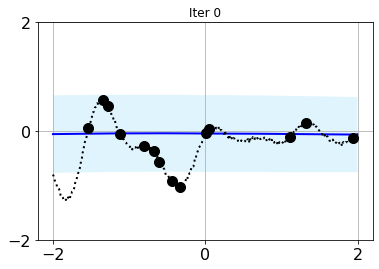

train: 100 loss= 0.4587 val_loss= 0.6413
train: 200 loss= 0.2329 val_loss= 0.6051
train: 300 loss= 0.3573 val_loss= 1.295
train: 400 loss= 0.426 val_loss= 0.5766
train: 500 loss=-0.08328 val_loss= 0.5137
train: 600 loss= 0.1441 val_loss= 1.05
train: 700 loss=-0.09933 val_loss= 1.253
train: 800 loss=-0.2678 val_loss= 0.8743
train: 900 loss= 0.04808 val_loss=-0.0923
train: 1000 loss= 0.3288 val_loss= 0.3959


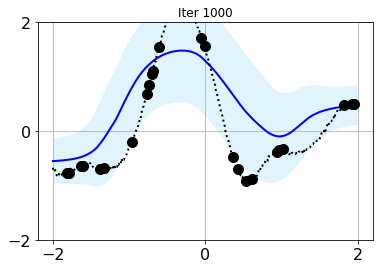

train: 1100 loss= 0.1042 val_loss= 0.8696
train: 1200 loss=-0.07648 val_loss= 0.7987
train: 1300 loss=-0.1327 val_loss= 0.5146
train: 1400 loss= 0.01851 val_loss= 1.122
train: 1500 loss=-0.1384 val_loss= 0.267
train: 1600 loss= 1.163 val_loss= 0.8228
train: 1700 loss= 0.002209 val_loss=-0.6582
train: 1800 loss= 0.02812 val_loss=-0.5332
train: 1900 loss= 0.03089 val_loss= 1.108
train: 2000 loss= 0.0444 val_loss= 0.268


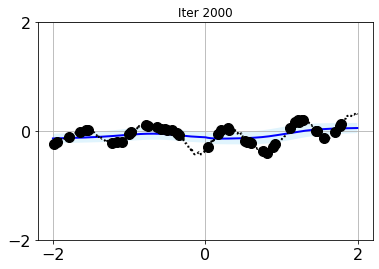

train: 2100 loss= 0.3157 val_loss= 0.2536
train: 2200 loss=-0.1212 val_loss= 1.005
train: 2300 loss=-0.1426 val_loss=-0.4149
train: 2400 loss= 0.4952 val_loss= 2.515
train: 2500 loss=-0.02337 val_loss= 0.6737
train: 2600 loss=-0.1221 val_loss= 1.173
train: 2700 loss=-0.2397 val_loss= 0.08649
train: 2800 loss=-0.262 val_loss= 2.026
train: 2900 loss= 0.3973 val_loss= 1.033
train: 3000 loss= 0.473 val_loss= 0.3988


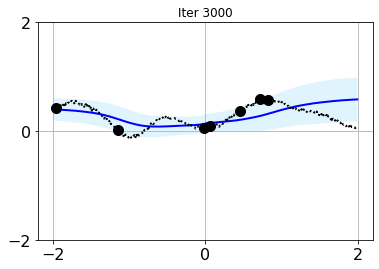

train: 3100 loss= 0.1286 val_loss= 0.7313
train: 3200 loss= 0.1505 val_loss=-0.4278
train: 3300 loss= 0.1239 val_loss= 0.07454
train: 3400 loss=-0.3603 val_loss=-0.6223
train: 3500 loss= 0.1256 val_loss= 0.1965
train: 3600 loss= 0.1861 val_loss= 0.3888
train: 3700 loss=-0.02808 val_loss=-1.615
train: 3800 loss= 0.002729 val_loss= 0.4251
train: 3900 loss= 0.09646 val_loss=-1.225
train: 4000 loss= 0.08507 val_loss= 0.1615


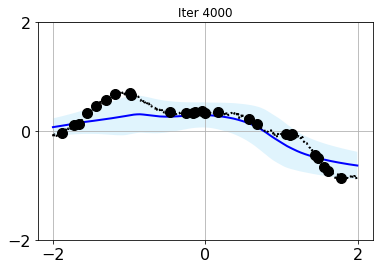

train: 4100 loss= 0.3127 val_loss= 0.002504
train: 4200 loss= 0.183 val_loss= 1.372
train: 4300 loss= 0.4749 val_loss=-0.8027
train: 4400 loss= 0.02496 val_loss= 0.5185
train: 4500 loss=-0.05285 val_loss= 1.298
train: 4600 loss=-0.059 val_loss=-0.7782
train: 4700 loss=-0.3106 val_loss=-0.7015
train: 4800 loss=-0.01025 val_loss= 0.03005
train: 4900 loss=-0.01599 val_loss= 1.313
train: 5000 loss=-0.03248 val_loss= 0.1122


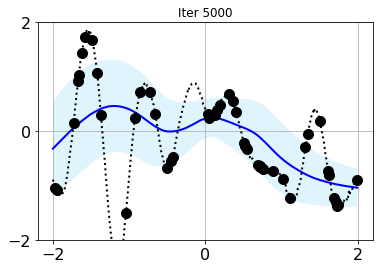

train: 5100 loss=-0.1601 val_loss=-0.7915
train: 5200 loss=-0.2264 val_loss= 0.02281
train: 5300 loss= 0.585 val_loss= 0.4562
train: 5400 loss= 0.00639 val_loss= 1.94
train: 5500 loss=-0.2998 val_loss=-0.02642
train: 5600 loss=-0.2697 val_loss= 0.4015
train: 5700 loss=-0.151 val_loss= 2.61
train: 5800 loss=-0.04946 val_loss= 0.03269
train: 5900 loss=-0.1889 val_loss=-0.07903
train: 6000 loss=-0.718 val_loss=-1.348


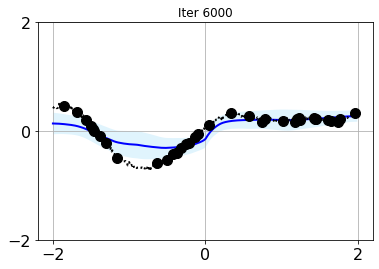

train: 6100 loss=-0.07253 val_loss=-0.06845
train: 6200 loss=-0.2002 val_loss= 0.758
train: 6300 loss=-0.2808 val_loss= 0.2902
train: 6400 loss= 0.1788 val_loss= 0.4741
train: 6500 loss=-0.1916 val_loss=-0.497
train: 6600 loss=-0.4884 val_loss= 0.1198
train: 6700 loss= 0.3179 val_loss=-1.102
train: 6800 loss=-0.2717 val_loss= 0.1815
train: 6900 loss= 0.1442 val_loss= 0.06652
train: 7000 loss=-0.2529 val_loss= 0.2183


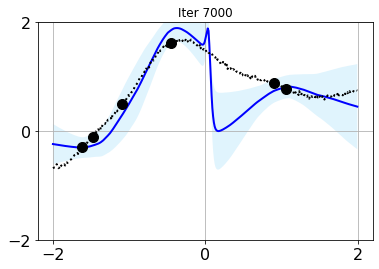

train: 7100 loss=-0.5139 val_loss=-1.043
train: 7200 loss= 0.1175 val_loss= 0.2555
train: 7300 loss=-0.01821 val_loss=-0.5002
train: 7400 loss=-0.1937 val_loss= 0.7815
train: 7500 loss=-0.2515 val_loss= 1.878
train: 7600 loss=-0.4304 val_loss= 0.2497
train: 7700 loss=-0.4573 val_loss=-0.5104
train: 7800 loss=-0.1097 val_loss=-1.595
train: 7900 loss=-0.169 val_loss=-0.5469
train: 8000 loss=-0.4157 val_loss=-0.652


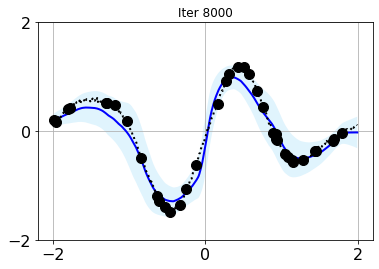

train: 8100 loss= 0.02136 val_loss=-0.3302
train: 8200 loss=-0.242 val_loss= 4.426
train: 8300 loss=-0.2305 val_loss=-0.1257
train: 8400 loss=-0.4046 val_loss= 0.007771
train: 8500 loss=-0.3791 val_loss=-0.5331
train: 8600 loss=-0.3371 val_loss= 0.4644
train: 8700 loss=-0.06009 val_loss= 1.061
train: 8800 loss=-0.01898 val_loss= 0.01321
train: 8900 loss=-0.7999 val_loss=-1.097
train: 9000 loss= 0.2256 val_loss=-0.1066


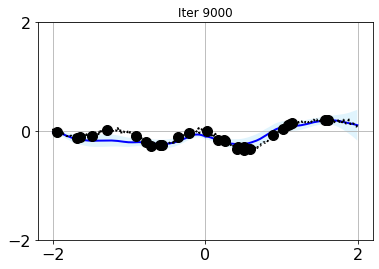

train: 9100 loss=-0.01695 val_loss=-0.6275
train: 9200 loss= 0.1429 val_loss= 0.3768
train: 9300 loss= 0.108 val_loss=-0.2208
train: 9400 loss=-0.4627 val_loss= 0.3817
train: 9500 loss=-0.5703 val_loss=-0.3627
train: 9600 loss=-0.2133 val_loss=-0.5779
train: 9700 loss=-0.5141 val_loss=-0.7667
train: 9800 loss=-0.605 val_loss=-0.194
train: 9900 loss= 0.4604 val_loss= 0.5109
train: 10000 loss= 0.08941 val_loss=-0.4082


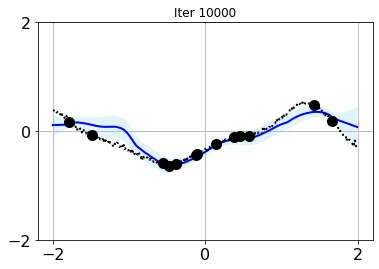

train: 10100 loss=-0.05301 val_loss= 0.3748
train: 10200 loss=-0.3752 val_loss=-0.7454
train: 10300 loss=-0.5065 val_loss=-1.36
train: 10400 loss=-0.1608 val_loss=-0.4235
train: 10500 loss=-0.3573 val_loss=-0.1387
train: 10600 loss=-0.007047 val_loss= 0.7716
train: 10700 loss=-0.002887 val_loss=-0.2827
train: 10800 loss=-0.6093 val_loss= 0.6792
train: 10900 loss=-0.3313 val_loss=-1.244
train: 11000 loss=-0.5322 val_loss= 0.9645


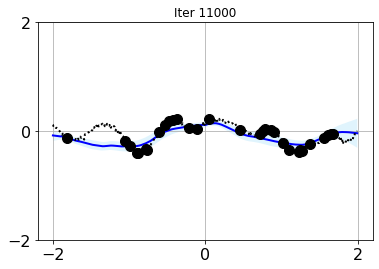

train: 11100 loss=-0.7242 val_loss= 0.5701
train: 11200 loss=-0.9163 val_loss= 1.758
train: 11300 loss=-0.7383 val_loss=-0.7432
train: 11400 loss=-0.3554 val_loss= 0.6336
train: 11500 loss=-0.3788 val_loss=-1.637
train: 11600 loss=-0.1507 val_loss= 0.947
train: 11700 loss= 0.2748 val_loss=-0.4106
train: 11800 loss=-0.8627 val_loss=-0.4712
train: 11900 loss=-0.02113 val_loss= 1.296
train: 12000 loss=-0.4049 val_loss= 1.174


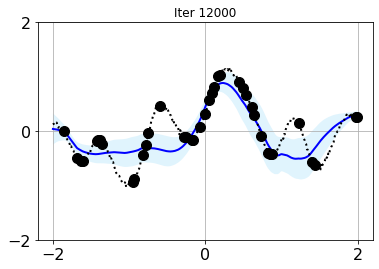

train: 12100 loss=-0.6371 val_loss= 1.407
train: 12200 loss=-0.7504 val_loss=-1.054
train: 12300 loss=-0.5446 val_loss=-1.731
train: 12400 loss=-0.6009 val_loss=-0.5427
train: 12500 loss=-0.3949 val_loss=-0.9042
train: 12600 loss=-0.4139 val_loss=-0.3413
train: 12700 loss=-0.7882 val_loss= 0.7199
train: 12800 loss=-0.2358 val_loss= 0.4558
train: 12900 loss=-0.133 val_loss= 1.631
train: 13000 loss=-0.8925 val_loss=-0.2054


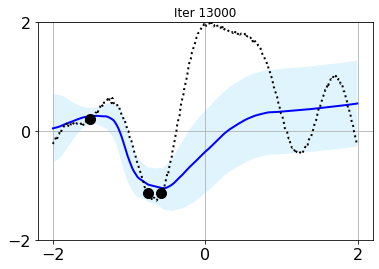

train: 13100 loss=-0.3349 val_loss= 0.6909
train: 13200 loss=-0.3534 val_loss=-0.5158
train: 13300 loss=-0.4553 val_loss= 1.181
train: 13400 loss=-0.2239 val_loss=-0.4758
train: 13500 loss=-0.5028 val_loss= 0.7517
train: 13600 loss=-0.5748 val_loss= 1.059
train: 13700 loss=-0.8389 val_loss= 0.08524
train: 13800 loss=-0.7235 val_loss= 0.2337
train: 13900 loss=-0.6328 val_loss=-0.4903
train: 14000 loss=-0.7552 val_loss= 0.6968


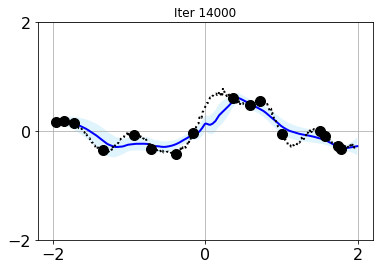

train: 14100 loss=-0.513 val_loss=-1.127
train: 14200 loss=-1.21 val_loss=-0.09703
train: 14300 loss=-0.4397 val_loss=-0.8424
train: 14400 loss=-0.7667 val_loss=-0.1598
train: 14500 loss=-0.5753 val_loss=-0.09461
train: 14600 loss=-0.5541 val_loss= 0.8457
train: 14700 loss=-0.2401 val_loss=-1.294
train: 14800 loss=-0.3916 val_loss= 0.8861
train: 14900 loss=-0.5086 val_loss=-0.8828
train: 15000 loss=-0.6116 val_loss=-0.2872


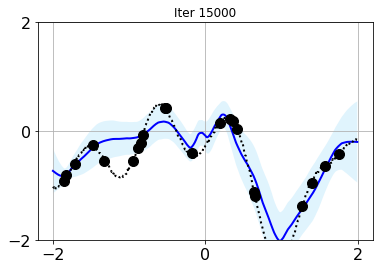

train: 15100 loss=-0.3264 val_loss=-0.9836
train: 15200 loss=-0.6587 val_loss=-0.5693
train: 15300 loss=-0.4401 val_loss=-1.634
train: 15400 loss=-0.6585 val_loss= 0.9375
train: 15500 loss=-0.5953 val_loss=-0.9451
train: 15600 loss=-0.7546 val_loss= 0.4929
train: 15700 loss=-0.9229 val_loss= 0.3884
train: 15800 loss=-0.5856 val_loss=-0.2925
train: 15900 loss=-0.2148 val_loss=-0.8883
train: 16000 loss=-0.7017 val_loss=-0.3683


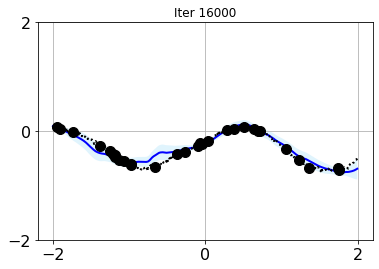

train: 16100 loss=-0.461 val_loss= 0.08153
train: 16200 loss=-0.6937 val_loss=-1.902
train: 16300 loss=-0.814 val_loss=-0.2374
train: 16400 loss=-0.5636 val_loss=-1.466
train: 16500 loss= 0.275 val_loss= 1.016
train: 16600 loss=-0.5511 val_loss=-0.8371
train: 16700 loss=-0.7323 val_loss= 0.9235
train: 16800 loss=-0.6481 val_loss=-0.06874
train: 16900 loss= 0.2401 val_loss=-1.002
train: 17000 loss=-0.1661 val_loss=-0.7689


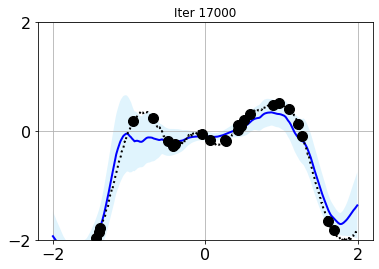

train: 17100 loss=-0.4972 val_loss= 2.187


KeyboardInterrupt: 

In [49]:


writer = SummaryWriter(comment='-anp_1d_reg')
print(writer.logdir)

hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="multihead",
    det_enc_self_attn_type="multihead",
    det_enc_cross_attn_type="multihead")
model = LatentModel(**hparams).cuda()

optim = torch.optim.Adam(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter % PLOT_AFTER == 0:
        test(model, dataset_test, writer, plot=True, global_step=n_iter)

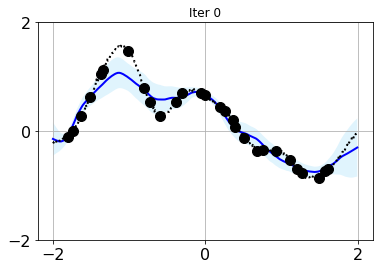

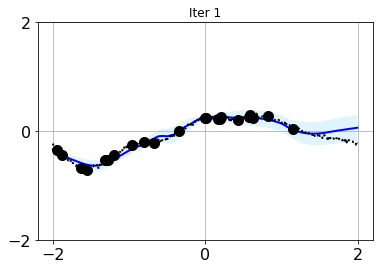

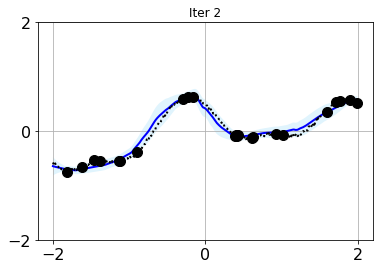

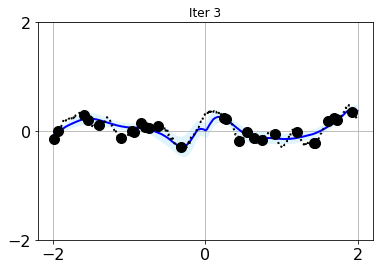

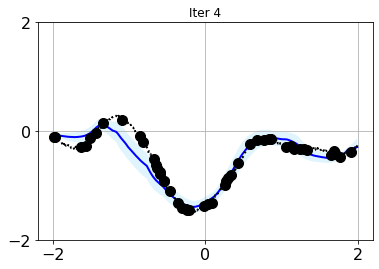

In [50]:
for i in range(5):
    set_seed(i)
    test(model, dataset_test, writer, plot=True, global_step=i)

In [51]:
# Final validation
loss = torch.stack([test(model, dataset_test)[2] for _ in tqdm(range(100))]).mean().cpu()
print('val loss (n=100)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))


val loss (n=100) tensor(-0.3734)


## Improved

These have no been extensively tested:

- use torches ~50% faster multiheaded attention
- calc loss in log domain for stability (and untested changes to clipping)
- dropout

runs/Feb01_13-37-12_mjcdesktop-anp_1d_impr


train: 0 loss= 1.039 val_loss= 0.977


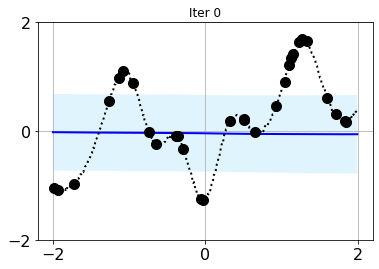

train: 100 loss= 0.7623 val_loss= 0.3867
train: 200 loss= 0.3706 val_loss= 1.19
train: 300 loss= 0.3864 val_loss=-0.298
train: 400 loss=-0.0994 val_loss= 0.5596
train: 500 loss= 0.1252 val_loss= 0.5187
train: 600 loss= 0.5242 val_loss=-0.9601
train: 700 loss= 0.3148 val_loss=-0.7317
train: 800 loss= 0.241 val_loss=-0.05659
train: 900 loss= 0.1712 val_loss=-0.8253
train: 1000 loss=-0.03109 val_loss= 0.8899


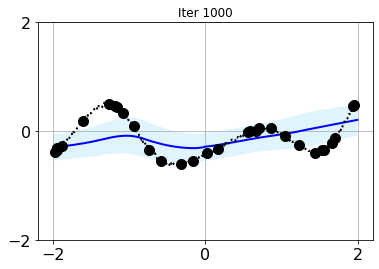

train: 1100 loss= 0.276 val_loss= 0.3529
train: 1200 loss= 0.2217 val_loss=-0.1563
train: 1300 loss= 0.5401 val_loss= 0.5245
train: 1400 loss= 0.8359 val_loss=-0.05774
train: 1500 loss= 0.3175 val_loss= 0.8792
train: 1600 loss=-0.09157 val_loss= 0.534
train: 1700 loss= 0.3483 val_loss= 0.1397
train: 1800 loss=-0.02089 val_loss= 2.601
train: 1900 loss= 0.2503 val_loss=-1.012
train: 2000 loss= 0.1343 val_loss= 0.3402


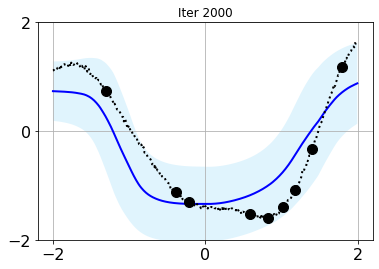

train: 2100 loss= 0.1657 val_loss=-0.2696
train: 2200 loss=-0.05159 val_loss=-1.301
train: 2300 loss= 0.8252 val_loss= 0.2365
train: 2400 loss= 0.3221 val_loss= 0.1705
train: 2500 loss= 0.04954 val_loss= 1.105
train: 2600 loss= 0.1437 val_loss=-0.7773
train: 2700 loss= 0.2654 val_loss=-0.4883
train: 2800 loss= 0.002986 val_loss= 0.595
train: 2900 loss= 0.07299 val_loss= 1.221
train: 3000 loss= 0.1594 val_loss=-1.085


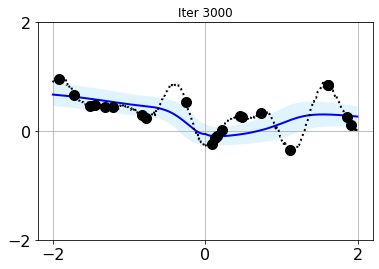

train: 3100 loss=-0.2822 val_loss= 0.935
train: 3200 loss=-0.1226 val_loss=-1.146
train: 3300 loss=-0.3602 val_loss=-0.001027
train: 3400 loss=-0.05214 val_loss= 0.2538
train: 3500 loss=-0.01916 val_loss= 0.1442
train: 3600 loss= 0.1837 val_loss= 1.818
train: 3700 loss=-0.1006 val_loss=-1.171
train: 3800 loss= 0.4553 val_loss= 0.005888
train: 3900 loss= 0.06757 val_loss= 0.5989
train: 4000 loss=-0.1009 val_loss= 1.03


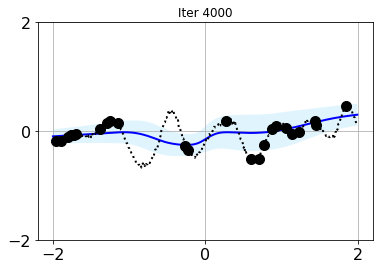

train: 4100 loss=-0.08626 val_loss=-1.088
train: 4200 loss= 0.2895 val_loss= 0.2456
train: 4300 loss=-0.1925 val_loss= 1.026
train: 4400 loss= 0.07102 val_loss=-0.6227
train: 4500 loss= 0.1956 val_loss=-1.439
train: 4600 loss=-0.2481 val_loss= 0.4849
train: 4700 loss= 0.07167 val_loss= 0.09917
train: 4800 loss=-0.1421 val_loss= 0.2718
train: 4900 loss= 0.006028 val_loss=-0.568
train: 5000 loss= 0.6336 val_loss= 0.3573


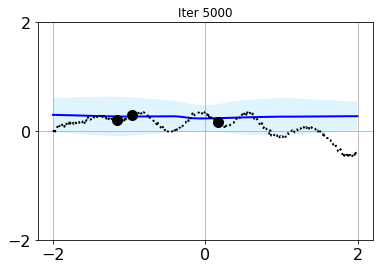

train: 5100 loss= 0.2498 val_loss=-0.289
train: 5200 loss=-0.2592 val_loss= 0.2616
train: 5300 loss= 0.1011 val_loss= 0.3723
train: 5400 loss=-0.1931 val_loss=-0.6247
train: 5500 loss=-0.06607 val_loss= 0.2876
train: 5600 loss= 0.4056 val_loss= 1.881
train: 5700 loss=-0.09319 val_loss= 0.4558
train: 5800 loss=-0.05693 val_loss= 0.3464
train: 5900 loss= 0.1772 val_loss= 1.176
train: 6000 loss= 0.3083 val_loss= 0.9466


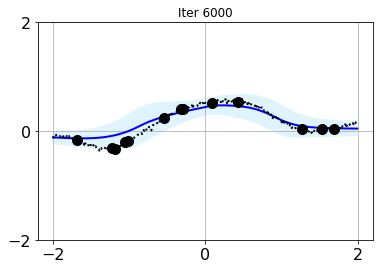

train: 6100 loss= 0.2372 val_loss=-0.1747
train: 6200 loss= 0.1842 val_loss=-0.544
train: 6300 loss= 0.01722 val_loss= 1.928
train: 6400 loss=-0.1007 val_loss= 0.4004
train: 6500 loss=-0.5583 val_loss=-0.3931
train: 6600 loss= 0.1616 val_loss= 0.6044
train: 6700 loss= 0.008324 val_loss= 1.023
train: 6800 loss=-0.3208 val_loss= 1.214
train: 6900 loss= 0.2049 val_loss=-1.457
train: 7000 loss=-0.133 val_loss= 1.104


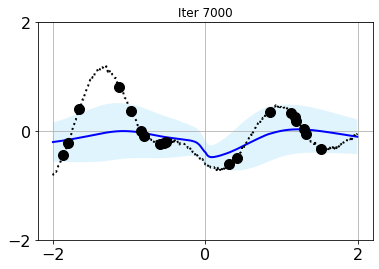

train: 7100 loss= 0.537 val_loss=-0.7977
train: 7200 loss= 0.0342 val_loss= 0.09855
train: 7300 loss=-0.03647 val_loss= 0.2884
train: 7400 loss=-0.1981 val_loss= 0.3704
train: 7500 loss= 0.7126 val_loss= 1.316
train: 7600 loss=-0.348 val_loss= 0.4829
train: 7700 loss= 0.08135 val_loss= 0.0479
train: 7800 loss=-0.2843 val_loss=-0.2877
train: 7900 loss=-0.2425 val_loss= 0.006385
train: 8000 loss= 0.1458 val_loss=-0.5802


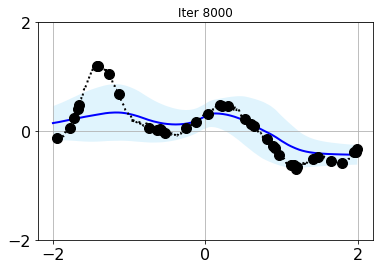

train: 8100 loss=-0.09388 val_loss= 0.8074
train: 8200 loss= 0.5295 val_loss=-0.03855
train: 8300 loss=-0.2468 val_loss= 0.3191
train: 8400 loss=-0.006748 val_loss=-0.5726
train: 8500 loss=-0.01523 val_loss=-0.5747
train: 8600 loss=-0.185 val_loss=-0.1271
train: 8700 loss=-0.2401 val_loss= 0.718
train: 8800 loss=-0.07328 val_loss= 0.6801
train: 8900 loss= 0.02403 val_loss=-0.01459
train: 9000 loss=-0.2013 val_loss= 0.521


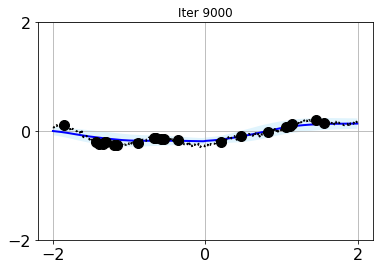

train: 9100 loss=-0.1517 val_loss= 0.6351
train: 9200 loss= 0.01878 val_loss=-1.601
train: 9300 loss=-0.2873 val_loss= 0.5382
train: 9400 loss=-0.368 val_loss= 0.2226
train: 9500 loss=-0.1312 val_loss= 0.122
train: 9600 loss= 0.1092 val_loss= 0.574
train: 9700 loss=-0.1897 val_loss= 0.7143
train: 9800 loss=-0.05511 val_loss=-1.12
train: 9900 loss=-0.1789 val_loss= 0.5659
train: 10000 loss= 0.1052 val_loss= 0.2109


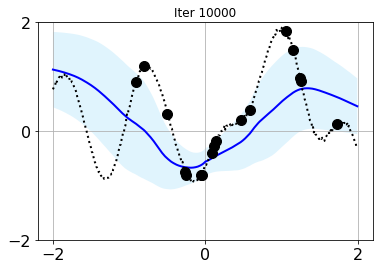

train: 10100 loss= 0.3435 val_loss=-1.024
train: 10200 loss=-0.5441 val_loss=-1.582
train: 10300 loss=-0.06787 val_loss= 0.05754
train: 10400 loss=-0.1438 val_loss= 1.388
train: 10500 loss=-0.2045 val_loss=-0.7681
train: 10600 loss=-0.1366 val_loss=-1.423
train: 10700 loss= 0.1097 val_loss=-0.4447
train: 10800 loss=-0.2119 val_loss= 0.278
train: 10900 loss= 0.05085 val_loss=-1.394
train: 11000 loss=-0.03985 val_loss= 0.5958


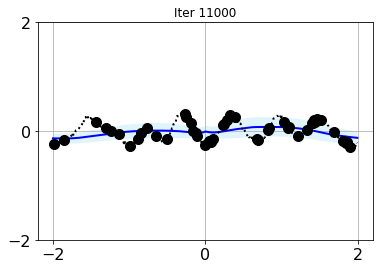

train: 11100 loss= 0.03565 val_loss=-1.404
train: 11200 loss=-0.02801 val_loss= 0.4441
train: 11300 loss=-0.04504 val_loss= 1.114
train: 11400 loss=-0.02241 val_loss=-0.2475
train: 11500 loss=-0.3711 val_loss=-0.558
train: 11600 loss=-0.1532 val_loss= 0.1785
train: 11700 loss= 0.07477 val_loss=-0.473
train: 11800 loss=-0.1822 val_loss=-0.5684
train: 11900 loss=-0.03746 val_loss=-0.867
train: 12000 loss=-0.2514 val_loss= 1.126


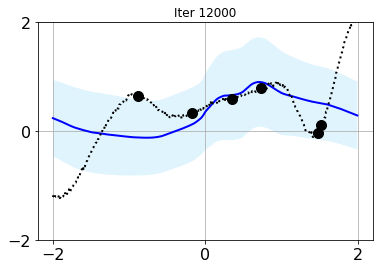

train: 12100 loss=-0.05926 val_loss=-0.2528
train: 12200 loss=-0.1158 val_loss=-0.5991
train: 12300 loss=-0.03047 val_loss=-0.01311
train: 12400 loss= 0.01211 val_loss= 0.8347
train: 12500 loss=-0.04894 val_loss=-0.1819
train: 12600 loss=-0.3594 val_loss=-0.1356
train: 12700 loss=-0.3144 val_loss= 1.275
train: 12800 loss=-0.1097 val_loss=-0.8694
train: 12900 loss= 0.0439 val_loss= 0.04395
train: 13000 loss=-0.2547 val_loss=-0.5634


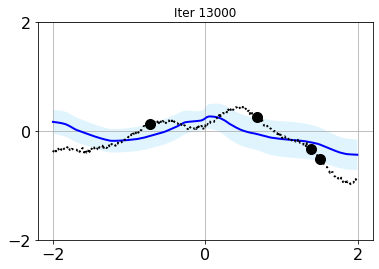

train: 13100 loss=-0.2292 val_loss= 1.13
train: 13200 loss=-0.2275 val_loss= 0.7303
train: 13300 loss=-0.0397 val_loss=-0.776
train: 13400 loss=-0.1191 val_loss=-1.057
train: 13500 loss= 0.3464 val_loss= 0.3227
train: 13600 loss=-0.3956 val_loss= 0.1288
train: 13700 loss=-0.5274 val_loss= 0.1126
train: 13800 loss=-0.5348 val_loss=-1.352
train: 13900 loss=-0.2926 val_loss=-0.04879
train: 14000 loss=-0.433 val_loss= 0.1232


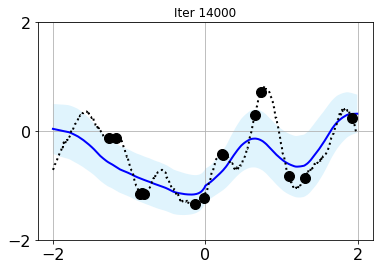

train: 14100 loss= 0.1482 val_loss= 0.3873
train: 14200 loss=-0.1044 val_loss= 1.047
train: 14300 loss=-0.4252 val_loss=-0.8185
train: 14400 loss=-0.6561 val_loss=-0.4372
train: 14500 loss=-0.1491 val_loss= 0.5137
train: 14600 loss=-0.2581 val_loss= 0.1739
train: 14700 loss=-0.5627 val_loss=-0.5216
train: 14800 loss=-0.1849 val_loss=-0.4823
train: 14900 loss=-0.3256 val_loss=-0.5338
train: 15000 loss=-0.5129 val_loss= 0.168


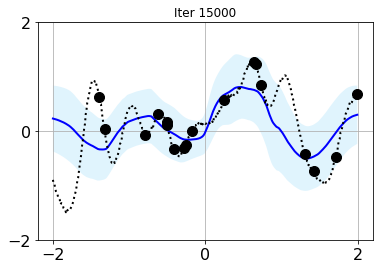

train: 15100 loss=-0.1113 val_loss= 0.4709
train: 15200 loss=-0.3564 val_loss=-1.028
train: 15300 loss=-0.3267 val_loss=-0.8836
train: 15400 loss=-0.7645 val_loss=-2.017
train: 15500 loss= 0.1093 val_loss=-1.408
train: 15600 loss=-0.2544 val_loss=-0.5028
train: 15700 loss=-0.4076 val_loss=-0.153
train: 15800 loss=-0.3934 val_loss=-0.3589
train: 15900 loss=-0.5154 val_loss= 0.3183
train: 16000 loss=-0.4195 val_loss= 0.8744


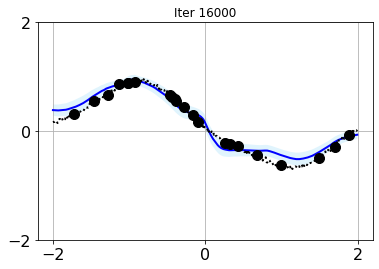

train: 16100 loss=-0.3771 val_loss=-0.8648
train: 16200 loss=-0.3697 val_loss= 0.4116
train: 16300 loss=-0.7703 val_loss=-0.08451
train: 16400 loss=-0.6524 val_loss= 0.3765
train: 16500 loss=-0.506 val_loss=-0.9506
train: 16600 loss=-0.4957 val_loss=-1.096
train: 16700 loss=-0.2465 val_loss=-1.852
train: 16800 loss=-0.6281 val_loss=-0.2986
train: 16900 loss=-0.4449 val_loss=-0.8501
train: 17000 loss=-0.0732 val_loss= 0.03449


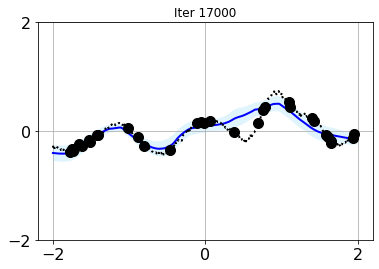

train: 17100 loss=-0.4799 val_loss=-1.078
train: 17200 loss=-0.4023 val_loss= 1.371
train: 17300 loss=-0.1958 val_loss=-1.817
train: 17400 loss=-0.1772 val_loss= 0.7967
train: 17500 loss=-0.057 val_loss= 0.1801
train: 17600 loss=-0.7193 val_loss=-0.9033
train: 17700 loss=-0.7074 val_loss= 0.583
train: 17800 loss=-0.7538 val_loss=-1.465
train: 17900 loss=-0.3393 val_loss=-1.665
train: 18000 loss=-0.803 val_loss=-1.735


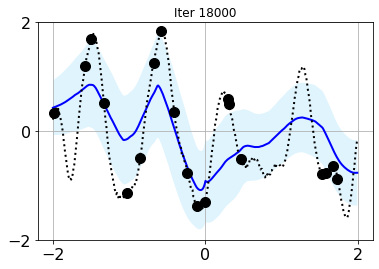

train: 18100 loss=-0.6292 val_loss=-0.8552
train: 18200 loss=-0.471 val_loss=-0.9578
train: 18300 loss= 0.08102 val_loss=-1.459
train: 18400 loss= 0.006321 val_loss= 1.206
train: 18500 loss=-0.7174 val_loss=-0.02062
train: 18600 loss=-0.7009 val_loss=-0.2288
train: 18700 loss=-0.4428 val_loss=-1.805
train: 18800 loss=-0.5278 val_loss=-0.6813
train: 18900 loss=-0.9495 val_loss=-1.304
train: 19000 loss=-0.745 val_loss= 1.022


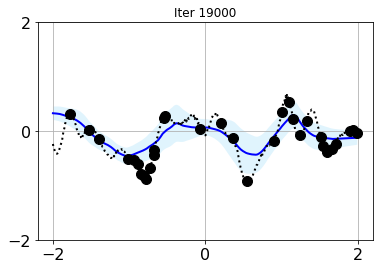

train: 19100 loss=-0.443 val_loss=-0.3791
train: 19200 loss=-0.5921 val_loss= 0.008461
train: 19300 loss=-0.75 val_loss=-0.2878
train: 19400 loss=-0.8855 val_loss=-0.04791
train: 19500 loss=-0.9537 val_loss=-1.002
train: 19600 loss=-0.6601 val_loss=-0.2613
train: 19700 loss=-0.8973 val_loss=-0.3152
train: 19800 loss=-0.678 val_loss=-0.2549
train: 19900 loss=-0.3991 val_loss= 0.2165
train: 20000 loss=-0.6135 val_loss= 0.3935


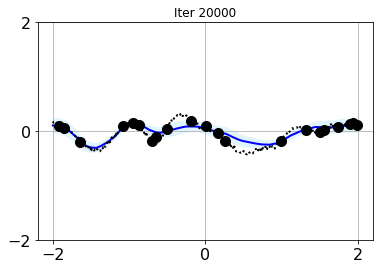

train: 20100 loss=-0.7885 val_loss=-0.1216
train: 20200 loss=-0.6422 val_loss=-0.08534
train: 20300 loss=-0.6466 val_loss=-0.6253
train: 20400 loss=-0.5918 val_loss= 0.4734
train: 20500 loss=-0.2635 val_loss= 0.2469
train: 20600 loss=-0.7682 val_loss= 0.4837
train: 20700 loss=-0.5694 val_loss=-0.2546
train: 20800 loss=-0.6407 val_loss=-0.9087
train: 20900 loss=-0.8286 val_loss= 0.7977
train: 21000 loss=-0.6536 val_loss=-0.6172


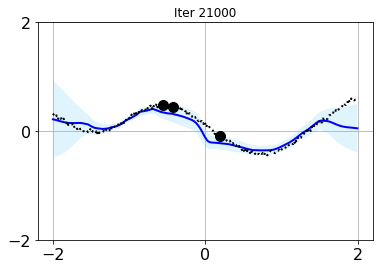

train: 21100 loss=-0.8329 val_loss= 0.9671
train: 21200 loss=-0.5352 val_loss=-0.4737
train: 21300 loss=-0.587 val_loss= 0.6567
train: 21400 loss=-0.5661 val_loss= 0.3783
train: 21500 loss=-0.8329 val_loss=-0.869
train: 21600 loss=-0.8147 val_loss= 0.4925
train: 21700 loss=-0.7199 val_loss=-1.789
train: 21800 loss=-0.6247 val_loss=-0.8712
train: 21900 loss=-0.4765 val_loss= 1.003
train: 22000 loss=-0.9676 val_loss=-0.7896


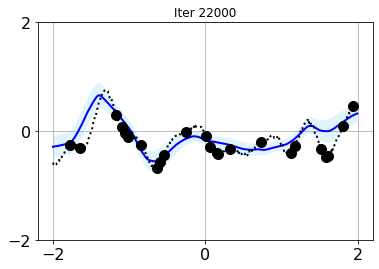

train: 22100 loss=-0.423 val_loss= 0.8429
train: 22200 loss=-0.5621 val_loss= 0.1087
train: 22300 loss=-0.6052 val_loss=-0.839
train: 22400 loss=-0.8363 val_loss=-1.515
train: 22500 loss=-1.003 val_loss= 0.4616
train: 22600 loss=-0.4579 val_loss= 0.1872
train: 22700 loss=-0.8777 val_loss=-1.451
train: 22800 loss=-0.6311 val_loss=-0.3955
train: 22900 loss=-0.6025 val_loss=-1.859
train: 23000 loss=-0.989 val_loss=-0.5167


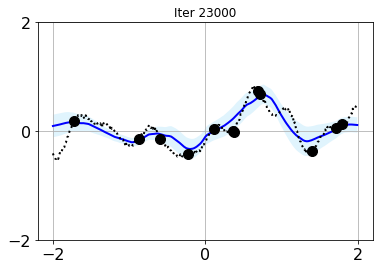

train: 23100 loss=-0.3262 val_loss= 0.1386
train: 23200 loss=-0.8418 val_loss=-0.204
train: 23300 loss=-0.4256 val_loss= 0.7147
train: 23400 loss=-0.05514 val_loss=-0.6206
train: 23500 loss=-0.9613 val_loss=-0.1759
train: 23600 loss=-0.9994 val_loss=-1.679
train: 23700 loss=-0.6065 val_loss= 0.2414
train: 23800 loss=-1.029 val_loss=-1.572
train: 23900 loss=-0.6648 val_loss=-1.479
train: 24000 loss=-0.8993 val_loss=-1.249


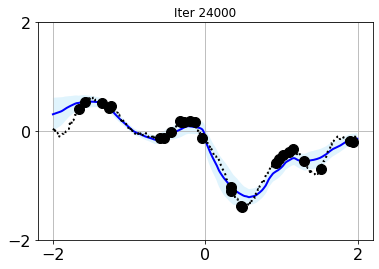

train: 24100 loss=-0.8363 val_loss=-1.305
train: 24200 loss=-0.969 val_loss=-2.024
train: 24300 loss=-0.7066 val_loss=-1.218
train: 24400 loss=-0.6798 val_loss=-0.1685
train: 24500 loss=-0.6615 val_loss=-0.3579
train: 24600 loss=-0.6935 val_loss=-1.572
train: 24700 loss=-0.8609 val_loss=-0.6895
train: 24800 loss=-0.4398 val_loss= 0.09986
train: 24900 loss=-0.3635 val_loss=-0.3017
train: 25000 loss=-0.4688 val_loss=-0.2981


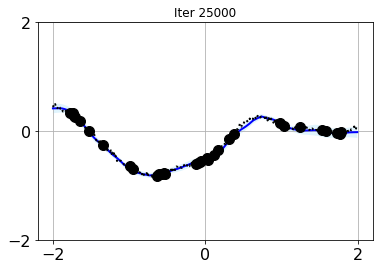

train: 25100 loss=-0.9488 val_loss=-0.1474
train: 25200 loss=-0.3297 val_loss=-1.011
train: 25300 loss=-0.456 val_loss=-1.434
train: 25400 loss=-0.9511 val_loss=-0.2257
train: 25500 loss=-0.6142 val_loss=-1.243
train: 25600 loss=-0.8807 val_loss= 0.9302
train: 25700 loss=-1.027 val_loss=-1.232
train: 25800 loss=-0.8108 val_loss=-1.419
train: 25900 loss=-0.5166 val_loss=-0.8665
train: 26000 loss=-1.283 val_loss=-1.126


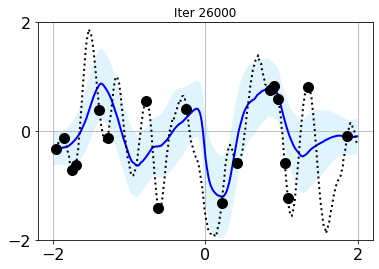

train: 26100 loss=-0.5863 val_loss=-0.7229
train: 26200 loss=-0.8655 val_loss=-1.92
train: 26300 loss=-1.017 val_loss=-0.6474
train: 26400 loss=-0.8469 val_loss=-0.5698
train: 26500 loss=-0.963 val_loss=-1.241
train: 26600 loss=-0.406 val_loss=-0.09626
train: 26700 loss=-0.9362 val_loss=-1.391
train: 26800 loss=-0.4968 val_loss= 0.3074
train: 26900 loss=-1.1 val_loss=-1.898
train: 27000 loss=-0.9641 val_loss=-1.104


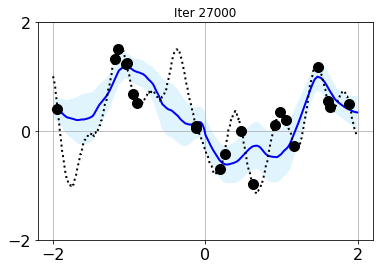

train: 27100 loss=-0.9856 val_loss=-1.542
train: 27200 loss=-0.8413 val_loss=  -1
train: 27300 loss=-0.6884 val_loss=-0.991
train: 27400 loss=-1.044 val_loss=-2.095
train: 27500 loss=-0.5066 val_loss= 0.3793
train: 27600 loss=-1.267 val_loss=-0.307
train: 27700 loss=-0.1859 val_loss=-0.01623
train: 27800 loss=-0.8349 val_loss=-1.251
train: 27900 loss=-0.1182 val_loss= 0.0003455
train: 28000 loss=-0.8981 val_loss=-0.3503


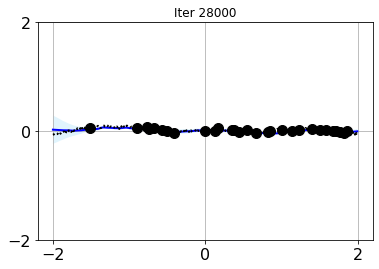

train: 28100 loss=-1.104 val_loss= 0.7331
train: 28200 loss=-0.832 val_loss=-0.8367
train: 28300 loss=-1.066 val_loss=-1.594
train: 28400 loss=-0.8164 val_loss=-1.621
train: 28500 loss=-0.4062 val_loss= 0.8909
train: 28600 loss=-0.9282 val_loss=-1.502
train: 28700 loss=-1.093 val_loss=-1.61
train: 28800 loss=-0.9918 val_loss=-1.965
train: 28900 loss=-0.5227 val_loss=-0.3909
train: 29000 loss=-1.076 val_loss= 0.25


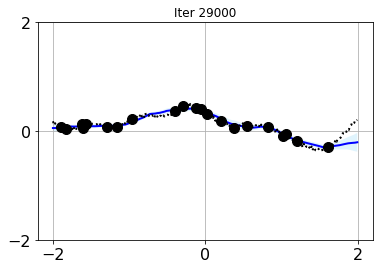

train: 29100 loss=-0.9038 val_loss=-1.109
train: 29200 loss=-0.5047 val_loss=-1.209
train: 29300 loss=-0.7126 val_loss=-0.4213
train: 29400 loss=-1.31 val_loss=-0.2392
train: 29500 loss=-0.9268 val_loss= 0.393
train: 29600 loss=-0.4297 val_loss=-0.6592
train: 29700 loss=-0.886 val_loss=-1.181
train: 29800 loss=-0.9377 val_loss=-0.383
train: 29900 loss=-1.27 val_loss=-0.2346
train: 30000 loss=-0.95 val_loss=-0.01757


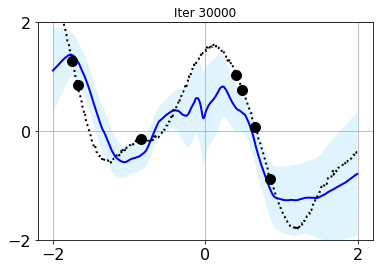

train: 30100 loss=-0.8309 val_loss= 0.03564
train: 30200 loss=-0.884 val_loss= 0.5868
train: 30300 loss=-1.089 val_loss=-0.648
train: 30400 loss=-1.089 val_loss=-1.864
train: 30500 loss=-1.126 val_loss=-1.869
train: 30600 loss=-0.832 val_loss=-0.6134
train: 30700 loss=-0.9598 val_loss=-1.281
train: 30800 loss=-0.9185 val_loss=-1.98
train: 30900 loss=-1.15 val_loss= 0.1247
train: 31000 loss=-0.9814 val_loss=-1.803


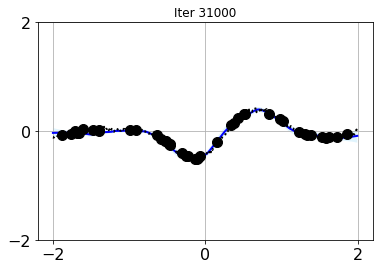

train: 31100 loss=-0.7972 val_loss=-0.8792
train: 31200 loss=-0.9479 val_loss=-1.753
train: 31300 loss=-1.083 val_loss=-2.03
train: 31400 loss=-1.023 val_loss=-0.007433
train: 31500 loss=-1.257 val_loss=-0.9109
train: 31600 loss=-0.9844 val_loss=-1.786
train: 31700 loss=-0.7705 val_loss=-0.8884
train: 31800 loss=-0.8803 val_loss=-1.853
train: 31900 loss=-0.9078 val_loss=-0.6613
train: 32000 loss=-1.05 val_loss=-1.456


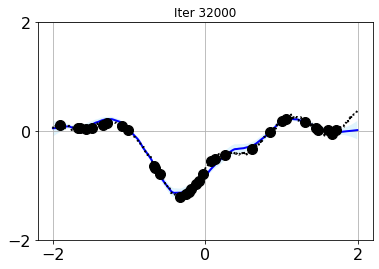

train: 32100 loss=-1.006 val_loss=-1.355
train: 32200 loss=-1.29 val_loss= 0.8605
train: 32300 loss=-0.8383 val_loss=-1.904
train: 32400 loss=-1.192 val_loss= 0.1759
train: 32500 loss=-1.358 val_loss=-1.902
train: 32600 loss=-1.054 val_loss=-1.041
train: 32700 loss=-1.142 val_loss=-1.158
train: 32800 loss=-1.038 val_loss=-0.955
train: 32900 loss=-0.6624 val_loss=-1.491
train: 33000 loss=-0.9378 val_loss=-1.356


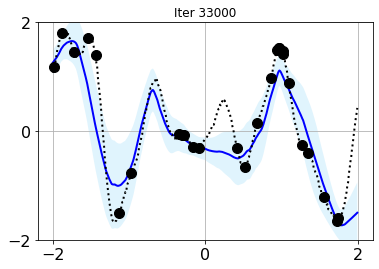

train: 33100 loss=-1.03 val_loss= 0.4903
train: 33200 loss=-0.8735 val_loss=-0.5836
train: 33300 loss=-1.057 val_loss= 0.9271
train: 33400 loss=-0.9608 val_loss= 1.218
train: 33500 loss=-0.6555 val_loss=-0.8867
train: 33600 loss=-1.279 val_loss=-0.814
train: 33700 loss=-0.9738 val_loss= 0.4817
train: 33800 loss=-1.178 val_loss=-1.282
train: 33900 loss=-1.074 val_loss=-0.2061
train: 34000 loss=-1.368 val_loss=-0.76


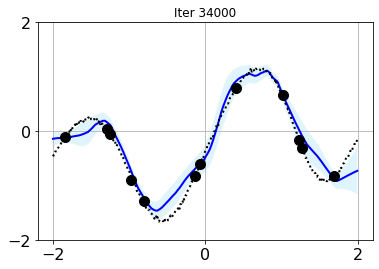

train: 34100 loss=-0.5816 val_loss=-1.118
train: 34200 loss=-0.7679 val_loss=-1.642
train: 34300 loss=-1.056 val_loss=-1.869
train: 34400 loss=-1.415 val_loss=-0.2941
train: 34500 loss=-0.7203 val_loss=-0.975
train: 34600 loss=-0.9827 val_loss=-0.6084
train: 34700 loss=-1.215 val_loss=-2.065
train: 34800 loss=-1.116 val_loss=-1.373
train: 34900 loss=-0.8175 val_loss=-1.527
train: 35000 loss=-1.327 val_loss= 1.132


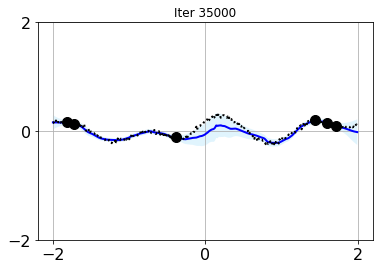

train: 35100 loss=-1.049 val_loss=-0.5873
train: 35200 loss=-1.332 val_loss= 0.2964
train: 35300 loss=-1.268 val_loss=-2.146
train: 35400 loss=-1.107 val_loss=-1.182
train: 35500 loss=-1.154 val_loss=-1.777
train: 35600 loss=-1.185 val_loss=-1.729
train: 35700 loss=-0.8592 val_loss=-2.069
train: 35800 loss=-1.218 val_loss=-0.9499
train: 35900 loss=-0.7109 val_loss=-0.2968
train: 36000 loss=-1.278 val_loss=-1.012


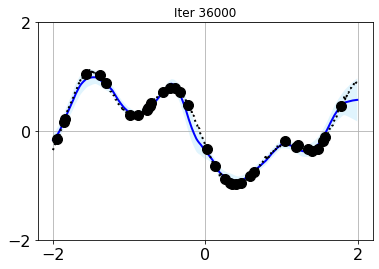

train: 36100 loss=-1.393 val_loss= 0.5763
train: 36200 loss=-1.195 val_loss=-1.757
train: 36300 loss=-1.1 val_loss=-1.513
train: 36400 loss=-0.6796 val_loss=-2.017
train: 36500 loss=-0.9187 val_loss=-2.045
train: 36600 loss=-0.1967 val_loss= 0.6478
train: 36700 loss=-1.268 val_loss= 0.1078
train: 36800 loss=-1.259 val_loss=-1.608
train: 36900 loss=-1.279 val_loss=-2.006
train: 37000 loss=-1.032 val_loss= 0.3818


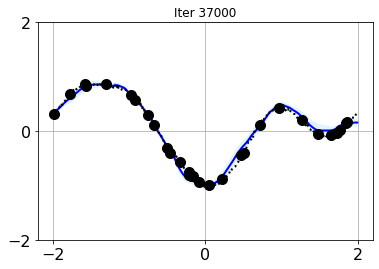

train: 37100 loss=-1.399 val_loss=-2.047
train: 37200 loss=-1.32 val_loss= 0.5514
train: 37300 loss=-1.357 val_loss=-1.527
train: 37400 loss=-0.9859 val_loss=-0.6536
train: 37500 loss=-0.8146 val_loss=-0.3132
train: 37600 loss=-0.6265 val_loss=-2.297
train: 37700 loss=-1.395 val_loss=-1.039
train: 37800 loss=-1.303 val_loss=-0.9378
train: 37900 loss=-0.9903 val_loss=-0.5269
train: 38000 loss=-1.333 val_loss=-1.516


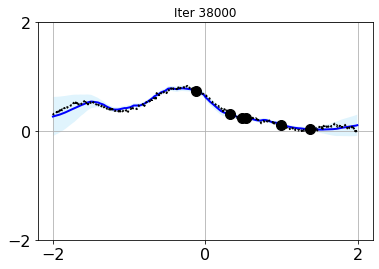

train: 38100 loss=-1.23 val_loss=-1.867
train: 38200 loss=-0.8651 val_loss=-1.169
train: 38300 loss=-1.219 val_loss=-0.5454
train: 38400 loss=-1.289 val_loss= 0.3086
train: 38500 loss=-0.9051 val_loss=-0.1192
train: 38600 loss=-1.22 val_loss=-1.76
train: 38700 loss=-0.4812 val_loss=-1.101
train: 38800 loss=-1.453 val_loss=-2.041
train: 38900 loss=-1.374 val_loss=-1.427
train: 39000 loss=-1.085 val_loss=-1.325


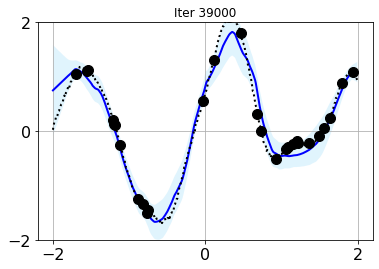

train: 39100 loss=-0.7866 val_loss= 0.4196
train: 39200 loss=-1.131 val_loss=-0.7496
train: 39300 loss=-1.235 val_loss=-1.754
train: 39400 loss=-1.055 val_loss=-0.6019
train: 39500 loss=-0.8433 val_loss=-0.9634
train: 39600 loss=-1.032 val_loss=-1.73
train: 39700 loss=-0.713 val_loss=-1.982
train: 39800 loss=-0.928 val_loss=-1.119
train: 39900 loss=-1.252 val_loss=-1.435
train: 40000 loss=-1.306 val_loss=-0.6615


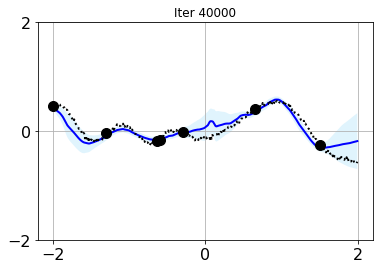

train: 40100 loss=-1.138 val_loss=-1.854
train: 40200 loss=-0.3067 val_loss=-0.404
train: 40300 loss=-1.527 val_loss=-1.087
train: 40400 loss=-1.211 val_loss=-0.6564
train: 40500 loss=-1.099 val_loss=-1.785
train: 40600 loss=-1.375 val_loss= 0.04172
train: 40700 loss=-0.8423 val_loss=-0.8787
train: 40800 loss=-0.9266 val_loss=-0.2179
train: 40900 loss=-1.044 val_loss=-1.415
train: 41000 loss=-1.662 val_loss=-0.8742


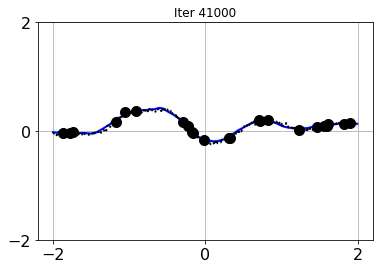

train: 41100 loss=-1.13 val_loss= 0.3008
train: 41200 loss=-1.231 val_loss= 0.281
train: 41300 loss=-0.7241 val_loss=-0.8537
train: 41400 loss=-1.201 val_loss= 0.4229
train: 41500 loss=-1.098 val_loss= 0.9764
train: 41600 loss=-1.329 val_loss=-1.509
train: 41700 loss=-1.138 val_loss=-1.017
train: 41800 loss=-1.343 val_loss=-1.856
train: 41900 loss=-0.8863 val_loss=-2.047
train: 42000 loss=-1.202 val_loss=-1.903


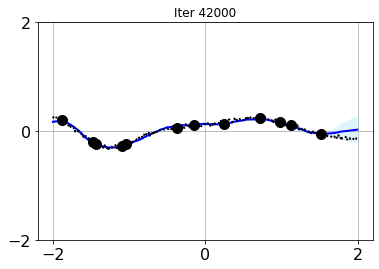

train: 42100 loss=-0.8168 val_loss=-1.985
train: 42200 loss=-0.3154 val_loss=-0.5077
train: 42300 loss=-1.489 val_loss=-0.6883
train: 42400 loss=-0.7153 val_loss=-0.4819
train: 42500 loss=-1.405 val_loss=-1.005
train: 42600 loss=-1.067 val_loss=-0.01977
train: 42700 loss=-1.084 val_loss=-1.12
train: 42800 loss=-1.359 val_loss=-0.8674
train: 42900 loss=-1.048 val_loss=-1.356
train: 43000 loss=-1.243 val_loss= 0.6259


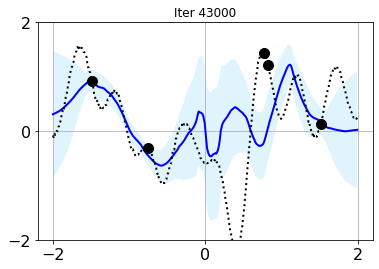

train: 43100 loss=-1.193 val_loss=-1.232
train: 43200 loss=-1.371 val_loss=-2.202
train: 43300 loss=-1.165 val_loss=-1.987
train: 43400 loss=-0.9554 val_loss=-0.8492
train: 43500 loss=-1.586 val_loss=-1.901
train: 43600 loss=-1.462 val_loss=-1.387
train: 43700 loss=-0.5139 val_loss=-1.665
train: 43800 loss=-0.9654 val_loss=-0.8994
train: 43900 loss=-1.344 val_loss=-1.075
train: 44000 loss=-1.331 val_loss= 0.9299


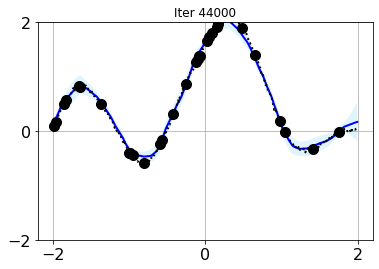

train: 44100 loss=-0.6639 val_loss=-1.69
train: 44200 loss=-1.179 val_loss=-1.865
train: 44300 loss=-0.9236 val_loss=-0.6522
train: 44400 loss=-1.345 val_loss= 0.5237
train: 44500 loss=-0.6449 val_loss=-1.784
train: 44600 loss=-1.281 val_loss=-1.512
train: 44700 loss=-0.8777 val_loss=-1.72
train: 44800 loss=-0.9429 val_loss=-1.56
train: 44900 loss=-1.498 val_loss=-0.7285
train: 45000 loss=-1.306 val_loss=-1.616


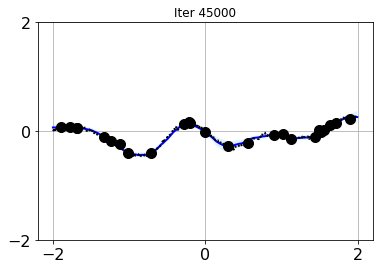

train: 45100 loss=-1.117 val_loss=-1.811
train: 45200 loss=-1.234 val_loss=-2.085
train: 45300 loss=-1.412 val_loss=-2.031
train: 45400 loss=-1.363 val_loss=-2.105
train: 45500 loss=-1.228 val_loss=-1.935
train: 45600 loss=-1.354 val_loss=-1.948
train: 45700 loss=-1.331 val_loss=-0.7241
train: 45800 loss=-1.285 val_loss=-0.06519
train: 45900 loss=-1.243 val_loss=-0.4891
train: 46000 loss=-1.185 val_loss= 0.08603


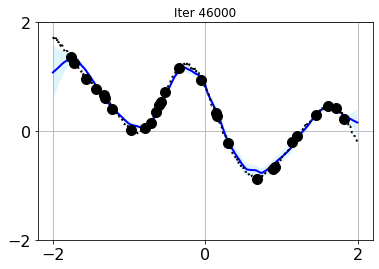

train: 46100 loss=-1.202 val_loss=-0.8481
train: 46200 loss=-1.173 val_loss=-0.8859
train: 46300 loss=-1.327 val_loss=-1.581
train: 46400 loss=-1.221 val_loss=-1.125
train: 46500 loss=-1.122 val_loss=-2.354
train: 46600 loss=-0.6656 val_loss=-0.3305
train: 46700 loss=-1.361 val_loss=-0.6259
train: 46800 loss=-1.09 val_loss=-0.3386
train: 46900 loss=-1.579 val_loss=-2.111
train: 47000 loss=-0.942 val_loss=-1.039


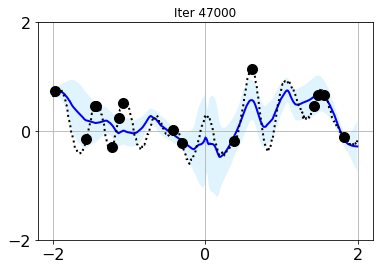

train: 47100 loss=-1.279 val_loss= 0.3887
train: 47200 loss=-0.9679 val_loss=-0.9047
train: 47300 loss=-1.031 val_loss=-1.216
train: 47400 loss=-0.7342 val_loss=-1.848
train: 47500 loss=-1.315 val_loss=-2.3
train: 47600 loss=-1.079 val_loss=-1.216
train: 47700 loss=-1.052 val_loss=-1.018
train: 47800 loss=-1.38 val_loss=-0.9418
train: 47900 loss=-1.231 val_loss=-0.6557
train: 48000 loss=-1.45 val_loss= 0.8068


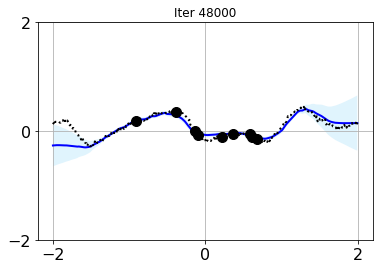

train: 48100 loss=-1.188 val_loss=-1.029
train: 48200 loss=-1.319 val_loss= 0.192
train: 48300 loss=-1.429 val_loss=-1.475
train: 48400 loss=-1.117 val_loss=-1.47
train: 48500 loss=-1.596 val_loss= 0.4329
train: 48600 loss=-1.802 val_loss=-1.149
train: 48700 loss=-1.405 val_loss=-0.454
train: 48800 loss=-1.323 val_loss=-0.3471
train: 48900 loss=-1.3 val_loss= 0.2884
train: 49000 loss=-1.185 val_loss=-0.9761


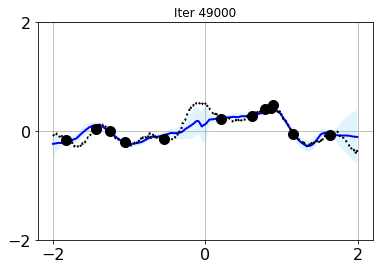

train: 49100 loss=-1.322 val_loss=-0.5198
train: 49200 loss=-1.109 val_loss=-0.5102
train: 49300 loss=-1.259 val_loss=-1.085
train: 49400 loss=-1.331 val_loss=-1.444
train: 49500 loss=-1.443 val_loss=-2.185
train: 49600 loss=-1.012 val_loss= 0.2187
train: 49700 loss=-1.366 val_loss=-0.1949
train: 49800 loss=-1.105 val_loss=-0.3544
train: 49900 loss=-1.008 val_loss=-1.136
train: 50000 loss=-1.661 val_loss=-1.903


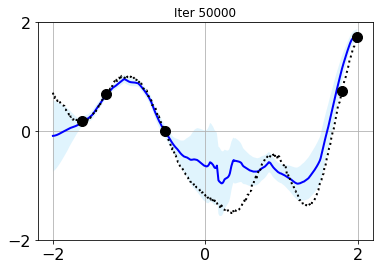

train: 50100 loss=-1.223 val_loss=-0.01081
train: 50200 loss=-1.433 val_loss=-0.2941
train: 50300 loss=-1.472 val_loss=-0.4925
train: 50400 loss=-1.517 val_loss=-1.557
train: 50500 loss=-1.169 val_loss=-1.844
train: 50600 loss=-1.496 val_loss=-1.555
train: 50700 loss=-0.6298 val_loss=-1.616
train: 50800 loss=-1.177 val_loss=-1.239
train: 50900 loss=-1.24 val_loss=-0.417
train: 51000 loss=-1.212 val_loss=-0.4843


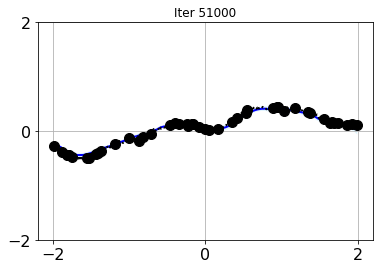

train: 51100 loss=-0.9646 val_loss=-0.499
train: 51200 loss=-1.105 val_loss=-0.32
train: 51300 loss=-1.549 val_loss=-0.5792
train: 51400 loss=-1.655 val_loss=-1.342
train: 51500 loss=-1.625 val_loss=-1.563
train: 51600 loss=-1.54 val_loss= 0.8583
train: 51700 loss=-1.275 val_loss=-1.119
train: 51800 loss=-1.157 val_loss=-0.2582
train: 51900 loss=-1.444 val_loss=-1.152
train: 52000 loss=-1.137 val_loss=-0.9984


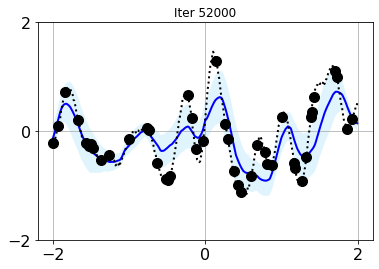

train: 52100 loss=-0.7188 val_loss=-0.7499
train: 52200 loss=-1.258 val_loss=-2.035
train: 52300 loss=-1.207 val_loss=-1.168
train: 52400 loss=-1.584 val_loss=-0.3692
train: 52500 loss=-1.668 val_loss=-0.3274
train: 52600 loss=-1.357 val_loss=-1.71
train: 52700 loss=-1.608 val_loss=-1.18
train: 52800 loss=-1.683 val_loss=-1.442
train: 52900 loss=-1.366 val_loss= 0.4052
train: 53000 loss=-1.302 val_loss=-1.754


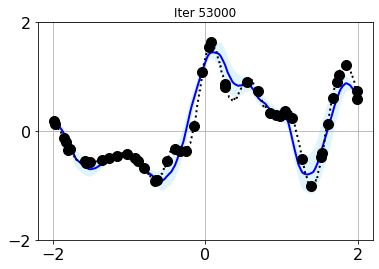

train: 53100 loss=-1.115 val_loss= 0.5424
train: 53200 loss=-1.391 val_loss= 1.283
train: 53300 loss=-1.761 val_loss=-1.965
train: 53400 loss=-0.9019 val_loss=-0.4109
train: 53500 loss=-1.42 val_loss=-1.712
train: 53600 loss=-1.348 val_loss=-0.2486
train: 53700 loss=-0.7523 val_loss=-1.557
train: 53800 loss=-1.767 val_loss=-0.5816
train: 53900 loss=-1.582 val_loss= 0.5013
train: 54000 loss=-1.043 val_loss=-1.341


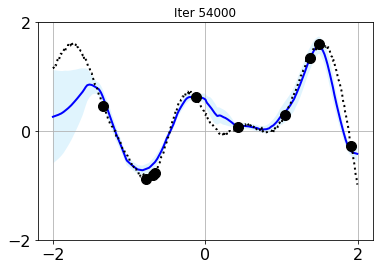

train: 54100 loss=-1.53 val_loss=-0.02711
train: 54200 loss=-1.491 val_loss=-1.789
train: 54300 loss=-1.002 val_loss=-0.4632
train: 54400 loss=-1.243 val_loss= 0.372
train: 54500 loss=-1.549 val_loss=-1.04
train: 54600 loss=-1.135 val_loss=-0.503
train: 54700 loss=-1.29 val_loss=-2.098
train: 54800 loss=-1.374 val_loss=-1.277
train: 54900 loss=-1.645 val_loss=-1.484
train: 55000 loss=-1.344 val_loss=-1.903


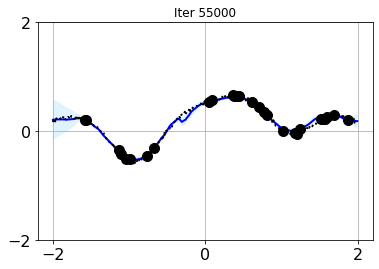

train: 55100 loss=-0.8998 val_loss= 0.1734
train: 55200 loss=-1.543 val_loss=-2.119
train: 55300 loss=-1.361 val_loss=-0.451
train: 55400 loss=-1.553 val_loss=-1.967
train: 55500 loss=-1.53 val_loss=-2.273
train: 55600 loss=-1.38 val_loss=-0.4848
train: 55700 loss=-1.403 val_loss=-2.022
train: 55800 loss=-0.8559 val_loss=-1.435
train: 55900 loss=-1.103 val_loss=-1.909
train: 56000 loss=-0.6221 val_loss=-0.98


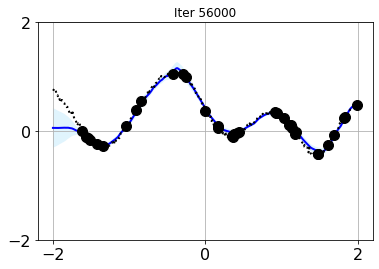

train: 56100 loss=-1.386 val_loss= 0.381
train: 56200 loss=-1.25 val_loss=-0.9118
train: 56300 loss=-0.8056 val_loss=-1.822
train: 56400 loss=-1.418 val_loss= 0.1938
train: 56500 loss=-1.444 val_loss=-2.009
train: 56600 loss=-1.171 val_loss=-1.132
train: 56700 loss=-1.058 val_loss=-0.2644
train: 56800 loss=-1.406 val_loss=-0.9517
train: 56900 loss=-1.537 val_loss=-1.798
train: 57000 loss=-1.658 val_loss=-1.416


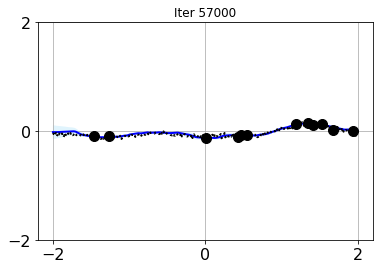

train: 57100 loss=-1.189 val_loss=-1.878
train: 57200 loss=-1.133 val_loss=-0.8194
train: 57300 loss=-1.039 val_loss=-1.127
train: 57400 loss=-1.205 val_loss=-0.6818
train: 57500 loss=-0.4594 val_loss=-1.245
train: 57600 loss=-1.617 val_loss=-1.696
train: 57700 loss=-1.394 val_loss=-1.905
train: 57800 loss=-1.16 val_loss=-0.4789
train: 57900 loss=-1.597 val_loss=-1.039
train: 58000 loss=-0.619 val_loss=-1.619


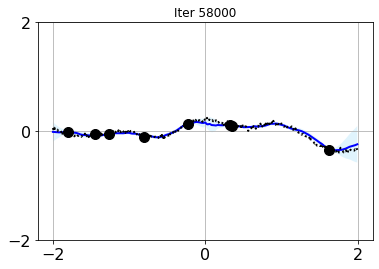

train: 58100 loss=-1.065 val_loss=-2.046
train: 58200 loss=-1.498 val_loss=-0.8687
train: 58300 loss=-1.507 val_loss=-0.7347
train: 58400 loss=-1.218 val_loss=-1.027
train: 58500 loss=-1.653 val_loss=-0.2914
train: 58600 loss=-1.476 val_loss=-1.702
train: 58700 loss=-1.479 val_loss=-1.843
train: 58800 loss=-1.802 val_loss= 1.201
train: 58900 loss=-1.6 val_loss=-1.976
train: 59000 loss=-1.008 val_loss=-1.861


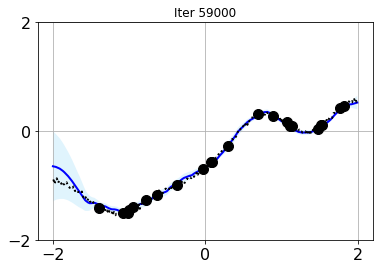

train: 59100 loss=-1.707 val_loss= 0.5792
train: 59200 loss=-1.524 val_loss=-0.7345
train: 59300 loss=-1.299 val_loss=-0.6762
train: 59400 loss=-1.355 val_loss= 0.648
train: 59500 loss=-1.488 val_loss=-1.77
train: 59600 loss=-1.68 val_loss=-1.91
train: 59700 loss=-1.515 val_loss=-1.175
train: 59800 loss=-1.494 val_loss= 0.7955
train: 59900 loss=-1.438 val_loss=-1.28
train: 60000 loss=-0.9282 val_loss=-1.292


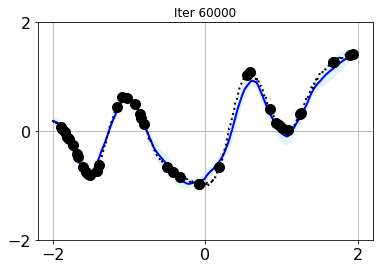

train: 60100 loss=-1.565 val_loss=-1.408
train: 60200 loss=-0.6043 val_loss= 0.548
train: 60300 loss=-1.273 val_loss=-1.81
train: 60400 loss=-1.646 val_loss=-2.1
train: 60500 loss=-1.523 val_loss=-1.879
train: 60600 loss=-1.363 val_loss=-1.438
train: 60700 loss=-1.383 val_loss=-1.431
train: 60800 loss=-0.71 val_loss=-1.497
train: 60900 loss=-1.272 val_loss= 0.7996
train: 61000 loss=-1.48 val_loss=-1.854


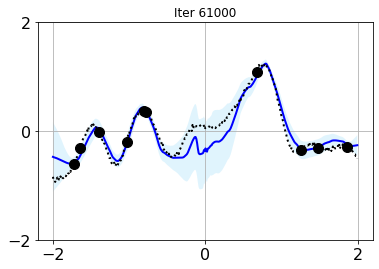

train: 61100 loss=-1.641 val_loss=-1.528
train: 61200 loss=-1.821 val_loss=-2.19
train: 61300 loss=-1.407 val_loss=-0.9567
train: 61400 loss=-1.116 val_loss= 0.2823
train: 61500 loss=-1.201 val_loss=-0.4331
train: 61600 loss=-1.617 val_loss= 0.6125
train: 61700 loss=-1.818 val_loss=-1.059
train: 61800 loss=-1.671 val_loss=-2.263
train: 61900 loss=-1.322 val_loss=-1.76
train: 62000 loss=-1.772 val_loss=-1.639


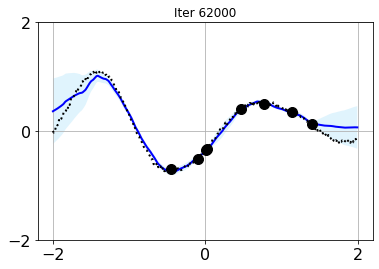

train: 62100 loss=-1.293 val_loss=-1.34
train: 62200 loss=-1.613 val_loss=-1.308
train: 62300 loss=-1.452 val_loss=-1.152
train: 62400 loss=-1.587 val_loss=-1.376
train: 62500 loss=-0.9709 val_loss=-1.042
train: 62600 loss=-1.106 val_loss=-1.481
train: 62700 loss=-1.612 val_loss=-2.213
train: 62800 loss=-1.632 val_loss=-1.823
train: 62900 loss=-1.179 val_loss=-0.3235
train: 63000 loss=-1.732 val_loss=-1.901


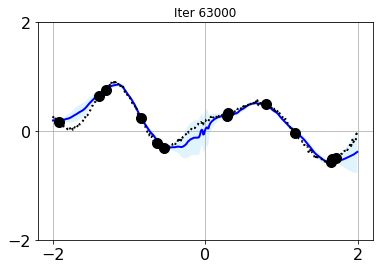

train: 63100 loss=-1.111 val_loss=-1.187
train: 63200 loss=-1.593 val_loss= 0.06745
train: 63300 loss=-1.381 val_loss=-1.936
train: 63400 loss=-0.4215 val_loss=-1.692
train: 63500 loss=-1.318 val_loss=-1.477
train: 63600 loss=-0.9636 val_loss=-0.2623
train: 63700 loss=-1.813 val_loss= 1.049
train: 63800 loss=-1.43 val_loss=-0.6259
train: 63900 loss=-0.8457 val_loss=-1.937
train: 64000 loss=-1.544 val_loss=-2.037


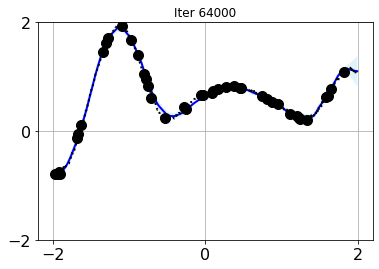

train: 64100 loss=-1.673 val_loss=-1.913
train: 64200 loss=-1.528 val_loss=-0.9585
train: 64300 loss=-1.71 val_loss=-0.8123
train: 64400 loss=-1.738 val_loss=-1.954
train: 64500 loss=-1.706 val_loss=-0.7583
train: 64600 loss=-1.467 val_loss=-1.762
train: 64700 loss=-0.7308 val_loss=-1.94
train: 64800 loss=-1.195 val_loss=-2.087
train: 64900 loss=-1.739 val_loss=-0.9937
train: 65000 loss=-1.643 val_loss=-2.249


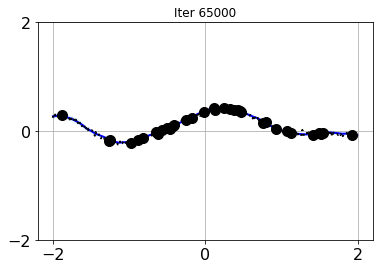

train: 65100 loss=-1.675 val_loss=-0.7784
train: 65200 loss=-1.221 val_loss=-2.148
train: 65300 loss=-1.007 val_loss=-1.701
train: 65400 loss=-1.33 val_loss=-2.033
train: 65500 loss=-1.274 val_loss=-1.356
train: 65600 loss=-0.7265 val_loss=-1.422
train: 65700 loss=-0.6911 val_loss=-1.606
train: 65800 loss=-1.328 val_loss=-2.105
train: 65900 loss=-1.245 val_loss=-1.853
train: 66000 loss=-1.444 val_loss=-1.807


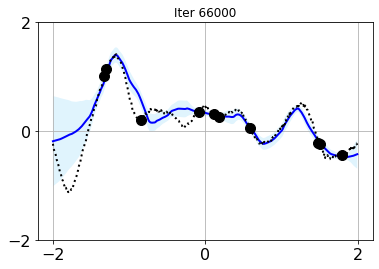

train: 66100 loss=-1.396 val_loss= 0.1181
train: 66200 loss=-1.73 val_loss=-1.105
train: 66300 loss=-1.713 val_loss=-1.061
train: 66400 loss=-1.736 val_loss=-1.269
train: 66500 loss=-1.195 val_loss= 0.9696
train: 66600 loss=-1.46 val_loss=-0.5126
train: 66700 loss=-1.441 val_loss=-1.904


KeyboardInterrupt: 

In [54]:
writer = SummaryWriter(comment='-anp_1d_impr')
print(writer.logdir)
                 
hparams = dict(
    x_dim=1,
    y_dim=1,
    hidden_dim=128,
    latent_dim=128,
    latent_enc_self_attn_type="ptmultihead",
    det_enc_self_attn_type="ptmultihead",
    det_enc_cross_attn_type="ptmultihead",
#     use_lvar=True,
    use_self_attn=True,
#     attention_dropout=0.3,
#     dropout=0.3,
#     batchnorm=True,
)
model = LatentModel(**hparams).cuda()

optim = torch.optim.Adam(model.parameters(), lr=1e-4)

for n_iter in tqdm(range(epochs)):
    model.train()

    data_train = dataset_train.generate_curves()

    (context_x, context_y), target_x = data_train.query
    target_y = data_train.target_y

    context_x = context_x.cuda()
    context_y = context_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    optim.zero_grad()
    y_pred, kl, loss, mse_loss, y_std = model(context_x, context_y, target_x,
                                              target_y)
    loss.backward()
    optim.step()

    writer.add_scalar('train/loss', loss, n_iter)
    writer.add_scalar('train/mse_loss', mse_loss, n_iter)
    writer.add_scalar('train/y_std', y_std.mean(), n_iter)
    writer.add_scalar('train/kl', kl.mean(), n_iter)

    if n_iter % PRINT_AFTER == 0:
        y_pred, kl, val_loss, y_std = test(
            model, dataset_test, writer, plot=False, global_step=n_iter)
        print(
            f"train: {n_iter} loss={loss.item(): 4.4g} val_loss={val_loss.item(): 4.4g}"
        )

    if n_iter % PLOT_AFTER == 0:
        test(model, dataset_test, writer, plot=True, global_step=n_iter)

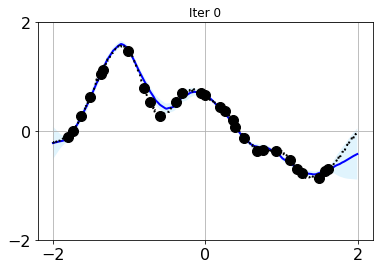

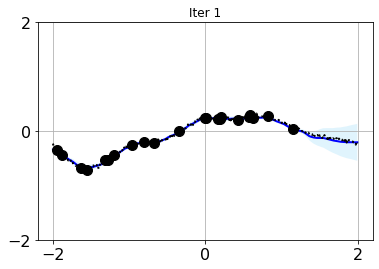

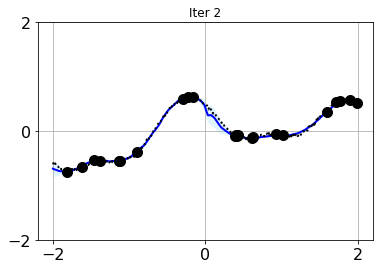

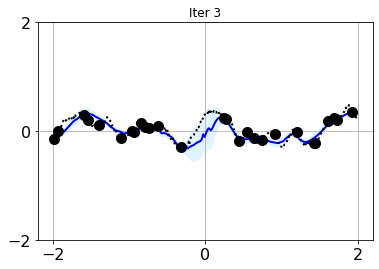

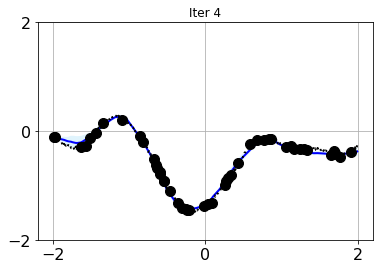

In [55]:
for i in range(5):
    set_seed(i)
    test(model, dataset_test, writer, plot=True, global_step=i)

In [56]:
# Final validation
loss = torch.stack([test(model, dataset_test)[2] for _ in tqdm(range(100))]).mean().cpu()
print('val loss (n=100)', loss)
writer.add_hparams(hparams, dict(val_loss=loss))


val loss (n=100) tensor(-1.2825)
